In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math as mt
from metpy.interpolate import interpolate_to_points
import scipy.optimize as spo
import time 

In [101]:
# creating the pulse field

def gen_field(dur_max, dur_step):
    pdur_i0 = ppau_i0 = np.arange(0, dur_max, dur_step)
    pdur_j, ppau_j = np.meshgrid(pdur_i0, ppau_i0)
    return pdur_j, ppau_j


In [102]:
#Plotting the data

def plot_field(pdur, ppau, res):
    plt.pcolor(pdur, ppau, res, cmap='Reds')
    plt.xlim(0, np.max(pdur))
    plt.ylim(0, np.max(ppau))
    plt.colorbar(label='Phonotaxis')
    plt.xlabel('Pulse [ms]')
    plt.ylabel('Pause [ms]')
    plt.show()

In [159]:
#filtering data to have similar chirp structure and eliminating redundancies in pulse pause and duration

def filter_data(x, dur_max):
    pd_df = x
    
    #finding frequency of each chirp duration
    (uniq, freq) = (np.unique(pd_df.CDUR, return_counts=True))
    xa = np.array([uniq,freq])
    xa = xa.astype(int)

    #finding the bracket of 61 values with the most data points
    jo = np.zeros(np.max(xa[0]))
    jo[xa[0]-1] = freq
    jo2 = []
    for i in range(30,len(jo)-30):
        jo2.append([i, np.sum(jo[i-30:i+30])])
    jo2 = np.array(jo2).T
    j = np.where(jo2 == np.max(jo2[1]))
    val = j[1][1] + 31

    #filtering down to values in the bracket calculated above
    x = pd_df.CDUR
    x1 = x>=(val-30)
    xa = pd_df[x1]
    x2 = xa.CDUR<=(val+30)
    xb = xa[x2]
    
    #repeating the same procedure for the values in chirp pause
    pd_df = xb
    (uniq, freq) = (np.unique(pd_df.CPAU, return_counts=True))
    xa = np.array([uniq,freq])
    xa = xa.astype(int)

    jo = np.zeros(np.max(xa[0]))
    jo[xa[0]-1] = freq
    jo2 = []
    for i in range(30,len(jo)-30):
        jo2.append([i, np.sum(jo[i-30:i+30])])
    jo2 = np.array(jo2).T
    j = np.where(jo2 == np.max(jo2[1]))
    val = j[1][1] + 31

    x = pd_df.CPAU
    x1 = x>=(val-30)
    xa = pd_df[x1]
    x2 = xa.CPAU<=(val+30)
    xb = xa[x2]

    #averaging the duplicates
    dfa = pd.DataFrame([xb.PDUR, xb.PPAU, xb.rXY]).T
    dfx = dfa.groupby(['PPAU', 'PDUR']).mean().reset_index()
    
    #filtering for values under the maximum duration specified
    check = dfx<=dur_max
    df_c = np.all(check,1)
    dfx = dfx[df_c]
    
    dfx = np.array([dfx.PDUR, dfx.PPAU, dfx.rXY]).T
    edg = [[0,0,0]]#, [0, dur_max, 0], [dur_max, dur_max, 0], [dur_max,0,0]] #initializing origin to zero (for smooth interpolation purposes)
    dfx = np.append(dfx, edg, axis = 0) 
    dfx = dfx.T
    
    plt.plot(dfx[0], dfx[1], 'o')
    plt.xlim(0, dur_max)
    plt.ylim(0, dur_max)
    plt.show()
    return dfx


In [172]:
#Importing data from file

def import_data(dur_max, dur_step):

    pd_df = pd.read_csv("dat/G13.txt")
    df = filter_data(pd_df, dur_max)
    
    pdur = df[0]
    ppau = df[1]
    phonotaxis = df[2]

    np.random.seed(10)
    # need to jitter data points slightly for interp to work - probably a bug in metpy
    points = np.array([pdur + np.random.randn(*pdur.shape)/10000000, ppau + np.random.randn(*ppau.shape)/10000000]).T

    # make new grid of points to interpolate to
    pdur_i0 = ppau_i0 = np.arange(0, dur_max, dur_step)
    pdur_i, ppau_i = np.meshgrid(pdur_i0, ppau_i0)
    new_points = np.array([pdur_i, ppau_i]).T.reshape((-1, 2))

    # natural neighbour interpolation 
    ppf = interpolate_to_points(points, phonotaxis, new_points, interp_type='natural_neighbor')
    ppf[np.isnan(ppf)] = 0 #np.nanmean(ppf)
    ppf = np.maximum(ppf, 0)  # set neg vals to 0
    ppf = ppf.reshape((len(pdur_i), len(ppau_i))).T  # make interpolated ppf square
    
    ppf /= np.max(ppf)
    return ppf


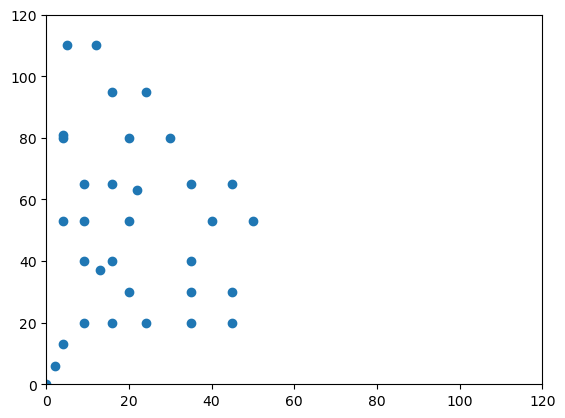

In [176]:
#defining some global variables that are constant and used throughout the code

dur_max = 120  # ms
dur_step = 2 # ms
global pnt_ori, pdur_i, ppau_i
pnt_ori = import_data(dur_max, dur_step)
pnt_ori /= np.max(pnt_ori)
# print(pnt_ori)
pdur_i, ppau_i = gen_field(dur_max, dur_step)

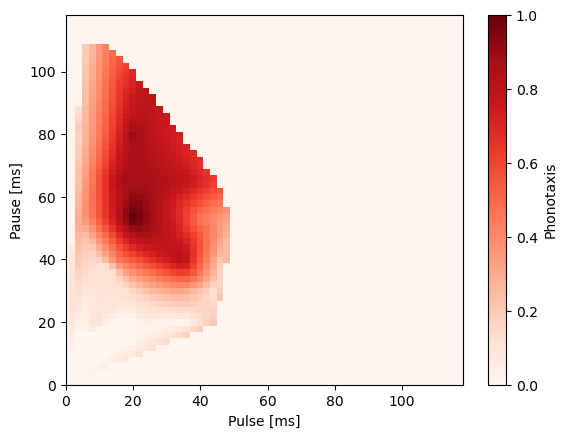

In [177]:
#For reference
plot_field(pdur_i, ppau_i, pnt_ori)

In [178]:
#generating the signal from the parameter duty cycle

def signal(idur, ipau, sf):
    sf = int(sf)
    unit = (sf/1000)
    dur = int(unit*idur)
    pau = int(unit*ipau)
    #print(dur, pau, unit)
    adur = np.ones(dur, dtype = int)
    apau = np.zeros(pau, dtype = int)
    aper = np.concatenate((adur,apau))
    sig2 = np.tile(aper, sf)
    if len(sig2)>sf:
        sig = sig2[0:sf]
    else:
        l = sf - len(sig2)
        sig3 = np.zeros(l, dtype = int)
        sig = np.concatenate((sig2, sig3))
    return sig

In [179]:
#The Gabor filter

def gabor(fr, sigma, phi, w, sf):
    border = int((3.5*sigma)) 
    t =  np.arange(-border, border, 1000/sf) #in ms
    gaussian = np.exp(-(t)**2/(2*sigma**2)) # in ms
    sinusoidal = np.sin(2*np.pi*(fr/1000)*t + phi) # in KHz, ms
    gbr =  gaussian * sinusoidal + w
    return gbr


In [180]:
#linear nonlinear filtering (including the integration)

def lin_nonlin(sig, gab, a1, b1):
    f1 = np.convolve(sig, gab) #linear filter
    
    g1 = 1/(1 + np.exp( -(a1 * f1) + b1)) # nonlinear sigmoid function

    #integral (which is basically summation)
    v1 = 0.001 * g1.sum()
    return v1

In [181]:
#extracting Phonotaxis value by pushing fabricated signal through filter

def phonotaxis(fr, sigma, phi, w, a1, b1, sf, t1, t2):
    sig1 = signal(t1, t2, sf)
    gab1 = gabor(fr, sigma, phi, w, sf)
    phntxs = lin_nonlin(sig1, gab1, a1, b1)
    return phntxs


In [182]:
#the entire model as a single function which is to be minimized 
#the function calculates the difference between the generated pulse-pause preference data and the actual experimental data imported earlier in the program.

def sig_diff(cfg):
    fr, sigma, ph, w, a1, b1 = cfg #unpacking the command from gods
    phi = np.pi * ph

    #generate field
    sf = 2000
    
    #calculating phonotaxis values
    phono = np.vectorize(phonotaxis)
    pnt = phono(fr, sigma, phi, w, a1, b1, sf, pdur_i, ppau_i)
    
    #normalization
    pnt = np.maximum(pnt, 0)
    pnt /= np.max(pnt)
    # if (np.max(pnt) - np.min(pnt)) > 0:
    #     pnt = (pnt - np.min(pnt))/(np.max(pnt) - np.min(pnt))
    # else:
    #     pnt = (pnt - np.min(pnt))
    #RMS of difference
    diff = np.sqrt(np.mean((pnt - pnt_ori)**2))
    
    return diff

In [183]:
#redundant function for crossverification and plotting

def sig_diff2(cfg):
    fr, sigma, ph, w, a1, b1 = cfg #unpacking the command from gods
    phi = np.pi * ph

    #generate field
    sf = 2000
    
    #calculating phonotaxis values
    phono = np.vectorize(phonotaxis)
    pnt = phono(fr, sigma, phi, w, a1, b1, sf, pdur_i, ppau_i)
    
    #normalization
    pnt = np.maximum(pnt, 0)
    pnt /= np.max(pnt)

    # if (np.max(pnt) - np.min(pnt)) > 0:
    #     pnt = (pnt - np.min(pnt))/(np.max(pnt) - np.min(pnt))
    # else:
    #     pnt = (pnt - np.min(pnt))
        
    #RMS of difference
    diff = np.sqrt(np.mean((pnt - pnt_ori)**2))
    
    return diff, pnt

0.2819062110998298


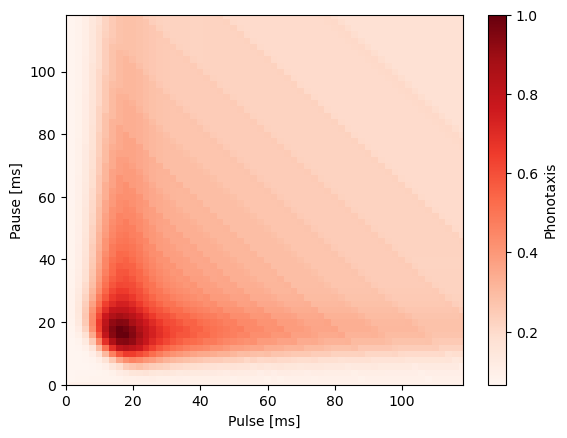

In [186]:
#setting initial values. and printing the start point of the minimize function present below
# cfg = [ 72.78,  8.571,  0.7359, -0.009, 0.3807,  3.733]
cfg = [30, 10, 0, 0.0, 0.31, 5]
y = sig_diff(cfg)
print(y)
xz = sig_diff2(cfg)
plot_field(pdur_i, ppau_i, xz[1])

In [187]:
#bounds of each parameter

b_fr = (0, 700)
b_sigma = (1, 501)
b_phi = (0, 2)
b_w = (-1, 1)
b_a1 = (0, np.inf)
b_b1 = (-np.inf, np.inf)

bnds = (b_fr, b_sigma, b_phi, b_w, b_a1, b_b1) #, b_dur_max, b_dur_step) #if necessary 


#Basin hopping minimization - to find the closest fit with the existing data without getting stuck in a local minima. , 'maxfev':1500  'options' : {"disp": True},  'bounds' : bnds, 
result = spo.basinhopping(sig_diff, cfg, niter = 100, T = 0.01, minimizer_kwargs={'options' : {"disp": True }, 'bounds' : bnds,  'method' : 'L-BFGS-B'}) #stepsize = 0.9,

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  2.81906D-01    |proj g|=  1.00000D+00

At iterate    1    f=  2.31725D-01    |proj g|=  7.67718D-01

At iterate    2    f=  2.11568D-01    |proj g|=  2.37165D-01

At iterate    3    f=  2.08153D-01    |proj g|=  1.69862D-01

At iterate    4    f=  2.03986D-01    |proj g|=  7.02005D-02

At iterate    5    f=  2.03172D-01    |proj g|=  4.20811D-02

At iterate    6    f=  2.02250D-01    |proj g|=  1.33314D-02

At iterate    7    f=  2.02146D-01    |proj g|=  9.15945D-03

At iterate    8    f=  2.02127D-01    |proj g|=  8.41123D-03

At iterate    9    f=  2.02126D-01    |proj g|=  8.40230D-03

At iterate   10    f=  2.02126D-01    |proj g|=  8.40208D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     11     97     13     0     0   8.402D-03   2.021D-01
  F =  0.20212634255871414     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  2.99128D-01    |proj g|=  1.89573D-03

At iterate    1    f=  2.99125D-01    |proj g|=  1.43704D-03

At iterate    2    f=  2.99111D-01    |proj g|=  1.17208D-03

At iterate    3    f=  2.99093D-01    |proj g|=  1.77703D-03

At iterate    4    f=  2.99046D-01    |proj g|=  1.95915D-03

At iterate    5    f=  2.98958D-01    |proj g|=  1.01772D-03

At iterate    6    f=  2.98695D-01    |proj g|=  2.95558D-04
  ys=-1.352E-04  -gs= 2.106E-04 BFGS update SKIPPED

At iterate    7    f=  2.98611D-01    |proj g|=  4.13536D-04

At iterate    8    f=  2.98360D-01    |proj g|=  1.85629D-05

At iterate    9    f=  2.98357D-01    |proj g|=  1.57652D-05

At iterate   10    f=  2.98349D-01    |proj g|=  6.43929D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   25    f=  2.02169D-01    |proj g|=  3.05365D-03

At iterate   26    f=  2.02168D-01    |proj g|=  3.06254D-03

At iterate   27    f=  2.02167D-01    |proj g|=  3.07003D-03

At iterate   28    f=  2.02167D-01    |proj g|=  3.07016D-03

At iterate   29    f=  2.02167D-01    |proj g|=  3.07016D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     29    107     30     1     1   3.070D-03   2.022D-01
  F =  0.20216675375642579     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.78219D-01    |proj g|=  9.77165D-01

At iterate    1    f=  2.46715D-01    |proj g|=  2.80779D-01

At iterate    2    f=  2.34559D-01    |proj g|=  1.67116D-01

At iterate    3    f=  2.01515D-01    |proj g|=  1.71643D-02

At iterate    4    f=  2.01481D-01    |proj g|=  1.86546D-02

At iterate    5    f=  2.00933D-01    |proj g|=  1.35611D-02

At iterate    6    f=  2.00391D-01    |proj g|=  1.21441D-02

At iterate    7    f=  2.00292D-01    |proj g|=  1.17548D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate    8    f=  2.00291D-01    |proj g|=  1.17513D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      9    119     13     0     0   1.175D-02   2.003D-01
  F =  0.20029140918436858     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.25650D-01    |proj g|=  5.02327D-01

At iterate    1    f=  5.03599D-01    |proj g|=  8.66492D-01
  ys=-5.238E-01  -gs= 3.536E-01 BFGS update SKIPPED

At iterate    2    f=  2.98645D-01    |proj g|=  6.40094D-04

At iterate    3  


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate    8    f=  2.98379D-01    |proj g|=  4.28102D-05



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate    9    f=  2.98379D-01    |proj g|=  4.27935D-05



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   10    f=  2.98379D-01    |proj g|=  4.27935D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     10    120     15     1     2   4.279D-05   2.984D-01
  F =  0.29837862961309491     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  2.08611D-01    |proj g|=  1.73230D-01

At iterate    1    f=  2.02861D-01    |proj g|=  1.25881D-01

At iterate    2    f=  2.02607D-01    |proj g|=  8.58293D-03

At iterate    3    f=  2.02521D-01    |proj g|=  8.53307D-03

At iterate    4    f=  2.02498D-01    |proj g|=  4.60151D-02

At iterate    5    f=  2.02487D-01    |proj g|=  9.35355D-02

At iterate    6    f=  2.02418D-01    |proj g|=  3.95056D-02

At iterate    7    f=  2.02393D-01    |proj g|=  2.60799D-02

At iterate    8    f=  2.02245D-01    |proj g|=  2.34770D-02

At iterate    9    f=  2.02024D-01    |proj g|=  6.54515D-02

At iterate   10    f=  2.01757D-01    |proj g|=  7.94294D-02

At iterate   11    f=  2.01668D-01    |proj g|=  6.45317D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   12    f=  2.01600D-01    |proj g|=  2.30046D-02

At iterate   13    f=  2.01589D-01    |proj g|=  2.76728D-03

At iterate   14    f=  2.01587D-01    |proj g|=  4.09251D-03

At iterate   15    f=  2.01581D-01    |proj g|=  7.76188D-03

At iterate   16    f=  2.01581D-01    |proj g|=  7.82952D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     17    112     19     0     1   7.830D-03   2.016D-01
  F =  0.20158107217205307     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.33368D-01    |proj g|=  1.26201D-01

At iterate    1    f=  2.10245D-01    |proj g|=  2.41119D-01
  ys=-1.411E-02  -gs= 1.656E-02 BFGS update SKIPPED

At iterate    2    f=  2.06071D-01    |proj g|=  3.89112D-02

At iterate    3    f=  2.05992D-01    |proj g|=  6.11085D-02

At iterate    4    f=  2.02474D-01    |proj g|=  6.04407D-02

At iterate    5    f=  2.02384D-01    |proj g|=  8.74646D-03

At iterate    6    f=  2.02381D-01    |proj g|=  9.76350D-03

At iterate    7    f=  2.02365D-01    |proj g|=  3.94640D-03

At iterate    8    f=  2.02358D-01    |proj g|=  2.42149D-03

At iterate    9    f=  2.02328D-01    |proj g|=  1.99224D-02

At iterate   10    f=  2.02282D-01    |proj g|=  3.83826D-02

At iterate   11    f=  2.02142D-01    |proj g|=  7.31766D-02

At iterate   12    f=  2.01956D-01  


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   14    f=  2.00086D-01    |proj g|=  7.30878D-02

At iterate   15    f=  2.00050D-01    |proj g|=  6.36131D-02

At iterate   16    f=  2.00004D-01    |proj g|=  4.95138D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   17    f=  1.99987D-01    |proj g|=  4.31029D-02

At iterate   18    f=  1.99986D-01    |proj g|=  4.28626D-02

At iterate   19    f=  1.99986D-01    |proj g|=  4.28573D-02

At iterate   20    f=  1.99986D-01    |proj g|=  4.28571D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     20    145     22     1     0   4.286D-02   2.000D-01
  F =  0.19998624131726128     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  2.56056D-01    |proj g|=  1.32862D-01

At iterate    1    f=  2.35632D-01    |proj g|=  1.74064D-01
  ys=-2.547E-03  -gs= 2.469E-02 BFGS update SKIPPED

At iterate    2    f=  2.06560D-01    |proj g|=  7.73370D-02

At iterate    3    f=  2.06448D-01    |proj g|=  1.42741D-02

At iterate    4    f=  1.98700D-01    |proj g|=  1.41215D-02

At iterate    5    f=  1.98538D-01    |proj g|=  2.20780D-02

At iterate    6    f=  1.98235D-01    |proj g|=  5.64582D-02

At iterate    7    f=  1.98195D-01    |proj g|=  6.01755D-02

At iterate    8    f=  1.98004D-01    |proj g|=  2.38361D-02

At iterate    9    f=  1.97893D-01    |proj g|=  5.92866D-03

At iterate   10    f=  1.97661D-01    |proj g|=  2.00835D-02

At iterate   11    f=  1.97607D-01    |proj g|=  2.31302D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   12    f=  1.97593D-01    |proj g|=  1.81736D-02

At iterate   13    f=  1.97570D-01    |proj g|=  5.36367D-03

At iterate   14    f=  1.97569D-01    |proj g|=  4.30515D-03

At iterate   15    f=  1.97568D-01    |proj g|=  3.63146D-03

At iterate   16    f=  1.97567D-01    |proj g|=  3.59862D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     17    145     19     1     0   3.599D-03   1.976D-01
  F =  0.19756746147056445     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.07408D-01    |proj g|=  1.89364D-01

At iterate    1    f=  2.03887D-01    |proj g|=  7.53565D-02

At iterate    2    f=  2.03626D-01    |proj g|=  1.51596D-02

At iterate    3    f=  2.03616D-01    |proj g|=  1.25555D-02

At iterate    4    f=  2.03609D-01    |proj g|=  5.60627D-03

At iterate    5    f=  2.03595D-01    |proj g|=  4.85342D-03

At iterate    6    f=  2.03306D-01    |proj g|=  4.45810D-02

At iterate    7    f=  2.02096D-01    |proj g|=  3.32305D-02

At iterate    8    f=  2.02087D-01    |proj g|=  2.31434D-02

At iterate    9    f=  2.02062D-01    |proj g|=  2.11637D-02

At iterate   10    f=  2.01889D-01    |proj g|=  8.38268D-03

At iterate   11    f=  2.01850D-01    |proj g|=  1.05150D-02

At iterate   12    f=  2.01837D-01    |proj g|=  1.51573D-02

At iterate   13    f=  2.0


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   14    f=  2.01777D-01    |proj g|=  1.93959D-02

At iterate   15    f=  2.01738D-01    |proj g|=  7.05187D-03

At iterate   16    f=  2.01730D-01    |proj g|=  6.47105D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   17    f=  2.01728D-01    |proj g|=  5.83789D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   18    f=  2.01728D-01    |proj g|=  5.75917D-03

At iterate   19    f=  2.01728D-01    |proj g|=  5.75734D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     20    179     24     0     0   5.757D-03   2.017D-01
  F =  0.20172783723082321     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.66613D-01    |proj g|=  1.33856D+00

At iterate    1    f=  3.02940D-01    |proj g|=  9.37356D-03

At iterate    2    f=  3.02742D-01    |proj g|=  7.47181D-03

At iterate    3    f=  3.02162D-01    |proj g|=  4.75666D-03

At iterate    4    f=  3.01558D-01    |proj g|=  2.51306D-03

At iterate    5    f=  3.01209D-01    |proj g|=  6.15397D-04

At iterate    6    f=  3.01180D-01    |proj g|=  5.35633D-04

At iterate    7    f=  3.01055D-01    |proj g|=  2.35711D-04

At iterate    8    f=  3.01005D-01    |proj g|=  1.36674D-04

At iterate    9    f=  3.00977D-01    |proj g|=  8.71025D-05

At iterate   10    f=  3.00977D-01    |proj g|=  8.69804D-05



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   11    f=  3.00977D-01    |proj g|=  8.69693D-05



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     12    104     18     0     2   8.697D-05   3.010D-01
  F =  0.30097726161302157     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.63087D-01    |proj g|=  2.54746D-01

At iterate    1    f=  2.41515D-01    |proj g|=  1.05495D-01

At iterate    2    f=  2.11916D-01    |proj g|=  9.05397D-02

At iterate    3    f=  2.10988D-01    |proj g|=  5.75942D-02

At iterate    4    f=  2.10743D-01    |proj g|=  4.48771D-02

At iterate    5    f=  2.04513D-01    |proj g|=  6.22149D-02

At iterate    6    f=  2.04368D-01    |proj g|=  5.36873D-02

At iterate    7    f=  2.04312D-01    |proj g|=  5.08761D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate    8    f=  2.04289D-01    |proj g|=  4.11790D-02

At iterate    9    f=  2.04289D-01    |proj g|=  4.08603D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     10    118     13     0     0   4.086D-02   2.043D-01
  F =  0.20428874644954689     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  9.20991D-01    |proj g|=  8.41622D+00

At iterate    1    f=  6.04095D-01    |proj g|=  5.32760D-01

At iterate    2    f=  2.23564D-01    |proj g|=  1.29406D-01

At iterate    3    f=  2.17142D-01    |proj g|=  7.41554D-02

At iterate    4    f=  2.12907D-01    |proj g|=  2.36405D-02

At iterate    5    f=  2.12886D-01    |proj g|=  1.67031D-02

At iterate    6    f=  2.03946D-01    |proj g|=  2.53707D-01
  Positive dir derivative in projection 
  Using the backtracking step 

At iterate    7    f=  2.03784D-01    |proj g|=  2.44404D-01

At iterate    8    f=  2.03443D-01    |proj g|=  2.05204D-01

At iterate    9    f=  2.02577D-01    |proj g|=  9.64731D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   10    f=  2.02460D-01    |proj g|=  5.79726D-02

At iterate   11    f=  2.02341D-01    |proj g|=  1.04631D-02

At iterate   12    f=  2.02335D-01    |proj g|=  4.44872D-03

At iterate   13    f=  2.02331D-01    |proj g|=  4.55304D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     14    100     16     0     0   4.553D-03   2.023D-01
  F =  0.20233081129578240     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.31488D-01    |proj g|=  8.89711D-01

At iterate    1    f=  2.17127D-01    |proj g|=  2.65944D-01

At iterate    2    f=  2.07307D-01    |proj g|=  9.54936D-02

At iterate    3    f=  2.06921D-01    |proj g|=  2.03546D-02

At iterate    4    f=  2.06624D-01    |proj g|=  2.77725D-02

At iterate    5    f=  2.03509D-01    |proj g|=  6.47634D-02

At iterate    6    f=  2.03509D-01    |proj g|=  6.51476D-02

At iterate    7    f=  2.03509D-01    |proj g|=  6.60333D-02

At iterate    8    f=  2.03509D-01    |proj g|=  6.63410D-02

At iterate    9    f=  2.03509D-01    |proj g|=  6.64277D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     11     81     12     0     0   4.570D-03   2.015D-01
  F =  0.20148438736375460     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.47180D-01    |proj g|=  1.67522D+00

At iterate    1    f=  2.02916D-01    |proj g|=  1.45181D-01

At iterate    2    f=  2.01271D-01    |proj g|=  2.42635D-02

At iterate    3    f=  2.01234D-01    |proj g|=  1.18695D-02

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   16    f=  2.00160D-01    |proj g|=  7.44230D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     17    137     19     0     0   7.442D-02   2.002D-01
  F =  0.20016049550938794     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.17162D-01    |proj g|=  6.11543D-01

At iterate    1    f=  3.12372D-01    |proj g|=  2.40672D-01

At iterate    2    f=  3.05469D-01    |proj g|=  3.49898D-02

At iterate    3    f=  3.03811D-01    |proj g|=  2.25746D-02

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   13    f=  2.99560D-01    |proj g|=  3.21759D-04

At iterate   14    f=  2.99560D-01    |proj g|=  3.21748D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     15    142     19     0     2   3.217D-04   2.996D-01
  F =  0.29955995550205605     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.08093D-01    |proj g|=  2.54210D-01

At iterate    1    f=  2.06990D-01    |proj g|=  3.69334D-02

At iterate    2    f=  2.06955D-01    |proj g|=  1.66631D-02

At iterate    3    f=  2.06934D-01    |proj g|=  1.75705D-02

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   22    f=  1.99552D-01    |proj g|=  1.38487D-02

At iterate   23    f=  1.99550D-01    |proj g|=  1.06445D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   24    f=  1.99550D-01    |proj g|=  1.02449D-02

At iterate   25    f=  1.99550D-01    |proj g|=  1.02410D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     25    161     27     0     1   1.024D-02   1.996D-01
  F =  0.19955031752539618     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  2.47042D-01    |proj g|=  5.58505D-01

At iterate    1    f=  2.02883D-01    |proj g|=  2.31148D-01

At iterate    2    f=  2.01243D-01    |proj g|=  5.70945D-02

At iterate    3    f=  2.00990D-01    |proj g|=  4.80319D-02

At iterate    4    f=  2.00838D-01    |proj g|=  1.81940D-02

At iterate    5    f=  2.00741D-01    |proj g|=  1.49114D-02

At iterate    6    f=  2.00678D-01    |proj g|=  2.03750D-02

At iterate    7    f=  2.00537D-01    |proj g|=  1.50356D-02

At iterate    8    f=  2.00489D-01    |proj g|=  3.48406D-03

At iterate    9    f=  2.00464D-01    |proj g|=  4.75900D-03

At iterate   10    f=  2.00445D-01    |proj g|=  8.20422D-03

At iterate   11    f=  2.00397D-01    |proj g|=  9.81213D-03

At iterate   12    f=  2.00282D-01    |proj g|=  4.59789D-03

At iterate   13    f=  2.0


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   22    f=  1.98600D-01    |proj g|=  1.58298D-02

At iterate   23    f=  1.98551D-01    |proj g|=  1.33475D-02

At iterate   24    f=  1.98379D-01    |proj g|=  2.27155D-02

At iterate   25    f=  1.98298D-01    |proj g|=  6.12440D-03

At iterate   26    f=  1.98282D-01    |proj g|=  2.04437D-03

At iterate   27    f=  1.98275D-01    |proj g|=  2.07178D-03

At iterate   28    f=  1.98251D-01    |proj g|=  3.19295D-03

At iterate   29    f=  1.98152D-01    |proj g|=  5.65470D-03

At iterate   30    f=  1.98130D-01    |proj g|=  5.06798D-03

At iterate   31    f=  1.98128D-01    |proj g|=  5.00029D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   32    f=  1.98128D-01    |proj g|=  4.85388D-03

At iterate   33    f=  1.98128D-01    |proj g|=  4.85199D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     33    152     35     0     0   4.852D-03   1.981D-01
  F =  0.19812831781663479     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  2.95054D-01    |proj g|=  7.32379D-01

At iterate    1    f=  2.49270D-01    |proj g|=  6.39337D-01

At iterate    2    f=  2.19451D-01    |proj g|=  2.02105D-01

At iterate    3    f=  2.05008D-01    |proj g|=  1.23312D-01

At iterate    4    f=  2.04387D-01    |proj g|=  8.95244D-02

At iterate    5    f=  2.03820D-01    |proj g|=  1.57471D-02

At iterate    6    f=  2.03750D-01    |proj g|=  1.32799D-02

At iterate    7    f=  2.03528D-01    |proj g|=  1.37384D-02

At iterate    8    f=  2.03490D-01    |proj g|=  7.22815D-03

At iterate    9    f=  2.03480D-01    |proj g|=  2.81276D-03

At iterate   10    f=  2.03474D-01    |proj g|=  3.56959D-03

At iterate   11    f=  2.03448D-01    |proj g|=  5.06430D-03

At iterate   12    f=  2.03389D-01    |proj g|=  1.40843D-02

At iterate   13    f=  2.0


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   42    f=  1.38189D-01    |proj g|=  2.06229D-03

At iterate   43    f=  1.38189D-01    |proj g|=  5.23900D-04

At iterate   44    f=  1.38189D-01    |proj g|=  5.21780D-04

At iterate   45    f=  1.38189D-01    |proj g|=  5.05565D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   46    f=  1.38189D-01    |proj g|=  4.97816D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   47    f=  1.38189D-01    |proj g|=  4.97019D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     48    201     52     1     0   4.970D-04   1.382D-01
  F =  0.13818852860756792     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.82867D-01    |proj g|=  2.93536D+00

At iterate    1    f=  2.06293D-01    |proj g|=  1.68421D-01

At iterate    2    f=  1.58939D-01    |proj g|=  8.70780D-02

At iterate    3    f=  1.58676D-01    |proj g|=  4.46391D-02

At iterate    4    f=  1.55576D-01    |proj g|=  5.72771D-02

At iterate    5    f=  1.49609D-01    |proj g|=  3.99880D-02

At iterate    6    f=  1.48616D-01    |proj g|=  1.09427D-01

At iterate    7    f=  1.48284D-01    |proj g|=  1.03948D-01

At iterate    8    f=  1.46416D-01    |proj g|=  3.18129D-02

At iterate    9    f=  1.46056D-01    |proj g|=  8.92884D-02

At iterate   10    f=  1.45803D-01    |proj g|=  7.12534D-02

At iterate   11    f=  1.45633D-01    |proj g|=  1.09055D-02

At iterate   12    f=  1.45620D-01    |proj g|=  5.78094D-03

At iterate   13    f=  1.4


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   48    f=  1.36322D-01    |proj g|=  1.39489D-03

At iterate   49    f=  1.36312D-01    |proj g|=  7.66101D-04

At iterate   50    f=  1.36285D-01    |proj g|=  1.23205D-02

At iterate   51    f=  1.36276D-01    |proj g|=  4.24698D-03

At iterate   52    f=  1.36266D-01    |proj g|=  2.13445D-03

At iterate   53    f=  1.36261D-01    |proj g|=  4.12863D-03

At iterate   54    f=  1.36253D-01    |proj g|=  7.49653D-03

At iterate   55    f=  1.36240D-01    |proj g|=  1.02373D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   56    f=  1.36237D-01    |proj g|=  4.34921D-03

At iterate   57    f=  1.36236D-01    |proj g|=  1.58879D-03

At iterate   58    f=  1.36235D-01    |proj g|=  2.11832D-03

At iterate   59    f=  1.36233D-01    |proj g|=  5.23734D-03

At iterate   60    f=  1.36227D-01    |proj g|=  1.16227D-02

At iterate   61    f=  1.36157D-01    |proj g|=  7.79971D-03
  ys=-2.015E-05  -gs= 5.479E-05 BFGS update SKIPPED

At iterate   62    f=  1.36157D-01    |proj g|=  7.77557D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   63    f=  1.36157D-01    |proj g|=  1.27143D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     63    230     66     3     0   1.271D+01   1.362D-01
  F =  0.13615692128445211     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.91748D-01    |proj g|=  8.57248D-03

At iterate    1    f=  2.91572D-01    |proj g|=  3.14123D-02
  ys=-2.262E-04  -gs= 8.401E-05 BFGS update SKIPPED

At iterate    2  


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.91689D-01    |proj g|=  4.62130D-05

At iterate    1    f=  2.91689D-01    |proj g|=  4.62186D-05
  ys=-2.565E-13  -gs= 2.643E-09 BFGS update SKIPPED

At iterate    2    f=  2.91669D-01    |proj g|=  7.15483D-05

At iterate    3    f=  2.91667D-01    |proj g|=  8.80407D-05

At iterate    4    f=  2.91661D-01    |proj g|=  6.82787D-05

At iterate    5    f=  2.91657D-01    |proj g|=  2.26485D-05

At iterate    6    f=  2.91656D-01    |proj g|=  2.09444D-05

At iterate    7    f=  2.91655D-01    |proj g|=  9.97535D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of 

/tmp/ipykernel_17967/901067433.py:6: RuntimeWarning: overflow encountered in exp
  g1 = 1/(1 + np.exp( -(a1 * f1) + b1)) # nonlinear sigmoid function



At iterate   11    f=  2.72792D-01    |proj g|=  2.00091D-01

At iterate   12    f=  2.72767D-01    |proj g|=  1.28902D-01

At iterate   13    f=  2.72733D-01    |proj g|=  2.42498D-02

At iterate   14    f=  2.72728D-01    |proj g|=  1.49750D-02

At iterate   15    f=  2.72721D-01    |proj g|=  6.16438D-02

At iterate   16    f=  2.72720D-01    |proj g|=  9.74854D-02
  Positive dir derivative in projection 
  Using the backtracking step 

At iterate   17    f=  2.69786D-01    |proj g|=  2.41848D-01

At iterate   18    f=  2.49726D-01    |proj g|=  8.35039D-02

At iterate   19    f=  2.48010D-01    |proj g|=  2.42005D-02

At iterate   20    f=  2.47824D-01    |proj g|=  2.17311D-02

At iterate   21    f=  2.47702D-01    |proj g|=  1.93395D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   22    f=  2.33119D-01    |proj g|=  7.78189D-02
  ys=-5.552E-06  -gs= 2.532E-03 BFGS update SKIPPED

At iterate   23    f=  2.33104D-01    |proj g|=  5.44250D-03

At iterate   24    f=  2.33103D-01    |proj g|=  8.99223D-03

At iterate   25    f=  2.33099D-01    |proj g|=  2.86787D-02

At iterate   26    f=  2.33082D-01    |proj g|=  7.56224D-02

At iterate   27    f=  2.33039D-01    |proj g|=  1.50056D-01

At iterate   28    f=  2.32876D-01    |proj g|=  3.15725D-01

At iterate   29    f=  2.31963D-01    |proj g|=  2.14627D-01

At iterate   30    f=  2.31962D-01    |proj g|=  1.84907D-01

At iterate   31    f=  2.31870D-01    |proj g|=  3.56204D-03

At iterate   32    f=  2.31870D-01    |proj g|=  1.69915D-03

At iterate   33    f=  2.31870D-01    |proj g|=  1.11167D-03

At iterate   34    f=  2.31870D-01    |proj g|=  4.17896D-04

At iterate   35    f=  2.31870D-01    |proj g|=  1.62311D-03

At iterate   36    f=  2.31869D-01    |proj g|=  4.36230D-03

At iterate   37  


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   51    f=  2.22348D-01    |proj g|=  5.03631D-02

At iterate   52    f=  2.22348D-01    |proj g|=  8.42857D+00



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     53    333     59     3     1   8.429D+00   2.223D-01
  F =  0.22234750351023094     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  5.96115D-01    |proj g|=  6.42124D-01

At iterate    1    f=  2.91071D-01    |proj g|=  1.49758D-04

At iterate    2    f=  2.91070D-01    |proj g|=  1.32816D-04

At iterate    3    f=  2.91066D-01    |proj g|=  4.82947D-05

At iterate    4    f=  2.91065D-01    |proj g|=  2.55684D-05

At iterate    5    f=  2.91063D-01    |proj g|=  3.26295D-05

At iterate    6    f=  2.91061D-01    |proj g|=  3.87856D-05

At iterate    7    f=  2.91048D-01    |proj g|=  5.28411D-05
  ys=-6.741E-06  -gs= 1.010E-05 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate    8    f=  2.91048D-01    |proj g|=  5.35405D-05
  ys=-5.555E-09  -gs= 4.390E-07 BFGS update SKIPPED

At iterate    9    f=  2.91030D-01    |proj g|=  2.44804D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      9     55     12     2     1   2.448D-06   2.910D-01
  F =  0.29102978703239285     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.12914D-01    |proj g|=  3.69381D-01

At iterate    1  


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   23    f=  1.37838D-01    |proj g|=  1.22550D-02

At iterate   24    f=  1.37837D-01    |proj g|=  3.96449D-03

At iterate   25    f=  1.37836D-01    |proj g|=  7.10451D-03

At iterate   26    f=  1.37832D-01    |proj g|=  1.54427D-02

At iterate   27    f=  1.37820D-01    |proj g|=  3.04104D-02

At iterate   28    f=  1.37805D-01    |proj g|=  3.78185D-02

At iterate   29    f=  1.37717D-01    |proj g|=  1.03637D-01

At iterate   30    f=  1.37630D-01    |proj g|=  6.54675D-02

At iterate   31    f=  1.37544D-01    |proj g|=  1.21934D-03

At iterate   32    f=  1.37543D-01    |proj g|=  1.18510D-03

At iterate   33    f=  1.37543D-01    |proj g|=  4.31377D-04

At iterate   34    f=  1.37543D-01    |proj g|=  4.24585D-04

At iterate   35    f=  1.37543D-01    |proj g|=  5.59647D-04

At iterate   36    f=  1.37543D-01    |proj g|=  1.34465D-03

At iterate   37    f=  1.37543D-01    |proj g|=  2.39378D-03

At iterate   38    f=  1.37543D-01    |proj g|=  4.16677D-03

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   68    f=  1.33417D-01    |proj g|=  2.95458D-04

At iterate   69    f=  1.33417D-01    |proj g|=  2.77803D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     69    186     71     1     1   2.778D-04   1.334D-01
  F =  0.13341749223614521     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  5.28331D-01    |proj g|=  6.79967D-01

At iterate    1    f=  2.92459D-01    |proj g|=  1.38944D-05

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   18    f=  2.77940D-01    |proj g|=  1.00499D-01

At iterate   19    f=  2.77938D-01    |proj g|=  2.89823D-02

At iterate   20    f=  2.77938D-01    |proj g|=  1.80600D-03

At iterate   21    f=  2.77938D-01    |proj g|=  3.53817D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     21     86     22     1     0   3.538D-04   2.779D-01
  F =  0.27793839549215854     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         1 variables are exactly at the bounds

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   12    f=  2.89198D-01    |proj g|=  2.92456D-01
  ys=-1.881E-02  -gs= 9.625E-06 BFGS update SKIPPED

At iterate   13    f=  2.73630D-01    |proj g|=  7.34623D-01

At iterate   14    f=  2.73624D-01    |proj g|=  6.47226D-03

At iterate   15    f=  2.73624D-01    |proj g|=  2.42930D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     15     83     16     2     0   2.429D-03   2.736D-01
  F =  0.27362350353447618     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0   


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   32    f=  1.33418D-01    |proj g|=  2.58416D-03

At iterate   33    f=  1.33418D-01    |proj g|=  1.29695D-03

At iterate   34    f=  1.33418D-01    |proj g|=  9.74862D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     35    145     39     1     0   9.749D-04   1.334D-01
  F =  0.13341842407171786     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  2.92255D-01    |proj g|=  2.85580D-03

At iterate    1    f=  2.92243D-01    |proj g|=  2.68098D-03

At iterate    2    f=  2.92128D-01    |proj g|=  9.91490D-04

At iterate    3    f=  2.92094D-01    |proj g|=  5.48872D-04

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   22    f=  1.33420D-01    |proj g|=  9.42052D-05

At iterate   23    f=  1.33420D-01    |proj g|=  1.06093D-04

At iterate   24    f=  1.33420D-01    |proj g|=  8.77740D-04

At iterate   25    f=  1.33420D-01    |proj g|=  1.49481D-03

At iterate   26    f=  1.33420D-01    |proj g|=  1.57032D-03

At iterate   27    f=  1.33420D-01    |proj g|=  1.59814D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   28    f=  1.33420D-01    |proj g|=  1.59839D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     28     92     31     0     1   1.598D-03   1.334D-01
  F =  0.13342003547241674     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  2.93278D-01    |proj g|=  5.90520D-03

At iterate    1    f=  2.93241D-01    |proj g|=  5.63137D-03

At iterate    2    f=  2.92750D-01    |proj g|=  2.05727D-03

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   48    f=  1.33411D-01    |proj g|=  1.44187D-04

At iterate   49    f=  1.33411D-01    |proj g|=  1.35233D-04

At iterate   50    f=  1.33411D-01    |proj g|=  1.20903D-04

At iterate   51    f=  1.33411D-01    |proj g|=  1.20820D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     51    143     52     1     0   1.208D-04   1.334D-01
  F =  0.13341077480674896     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.93918D-01    |proj g|=  3.48657D-03

At iterate    1    f=  2.93894D-01    |proj g|=  3.41185D-03

At iterate    2    f=  2.77464D-01    |proj g|=  3.29525D-01

At iterate    3    f=  2.68787D-01    |proj g|=  6.43763D-02
  Positive dir derivative in projection 
  Using the backtracking step 

At iterate    4    f=  2.06192D-01    |proj g|=  3.29428D-01

At iterate    5    f=  2.06039D-01    |proj g|=  6.77422D-01

At iterate    6    f=  2.05607D-01    |proj g|=  3.16055D-01

At iterate    7    f=  2.05348D-01    |proj g|=  2.20070D-01

At iterate    8    f=  2.05326D-01    |proj g|=  9.30745D-02

At iterate    9    f=  2.05310D-01    |proj g|=  8.52387D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   10    f=  1.77638D-01    |proj g|=  5.88619D-02

At iterate   11    f=  1.77611D-01    |proj g|=  1.66422D-03

At iterate   12    f=  1.77611D-01    |proj g|=  2.79720D-03

At iterate   13    f=  1.77611D-01    |proj g|=  8.26337D-03

At iterate   14    f=  1.77610D-01    |proj g|=  8.41792D-03

At iterate   15    f=  1.77605D-01    |proj g|=  1.69247D-03

At iterate   16    f=  1.77581D-01    |proj g|=  6.77426D-02

At iterate   17    f=  1.77549D-01    |proj g|=  6.60405D-02

At iterate   18    f=  1.76942D-01    |proj g|=  3.06316D-01

At iterate   19    f=  1.76923D-01    |proj g|=  2.69660D-01

At iterate   20    f=  1.76913D-01    |proj g|=  2.19495D-01

At iterate   21    f=  1.76907D-01    |proj g|=  1.81719D-01

At iterate   22    f=  1.76902D-01    |proj g|=  1.44725D-01

At iterate   23    f=  1.76885D-01    |proj g|=  1.65247D-02

At iterate   24    f=  1.76880D-01    |proj g|=  3.63528D-02

At iterate   25    f=  1.76867D-01    |proj g|=  2.83970D-02

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   34    f=  1.73200D-01    |proj g|=  1.08174D-02

At iterate   35    f=  1.73200D-01    |proj g|=  7.79121D-03

At iterate   36    f=  1.73200D-01    |proj g|=  1.46723D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   37    f=  1.73200D-01    |proj g|=  8.41855D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     38    248     42     3     0   8.419D-03   1.732D-01
  F =  0.17319997058133174     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  1.42602D-01    |proj g|=  8.74710D-01

At iterate    1    f=  1.39474D-01    |proj g|=  4.75438D-02

At iterate    2    f=  1.39463D-01    |proj g|=  3.70554D-02

At iterate    3    f=  1.39399D-01    |proj g|=  7.51065D-02

At iterate    4    f=  1.39284D-01    |proj g|=  1.21571D-01

At iterate    5    f=  1.38954D-01    |proj g|=  2.06701D-01

At iterate    6    f=  1.34523D-01    |proj g|=  1.49668D-01

At iterate    7    f=  1.33683D-01    |proj g|=  1.44818D-02

At iterate    8    f=  1.33658D-01    |proj g|=  2.87304D-02

At iterate    9    f=  1.33653D-01    |proj g|=  1.51961D-02

At iterate   10    f=  1.33650D-01    |proj g|=  8.71948D-03

At iterate   11    f=  1.33647D-01    |proj g|=  4.92939D-04

At iterate   12    f=  1.33647D-01    |proj g|=  5.06525D-04

At iterate   13    f=  1.3


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   43    f=  1.33414D-01    |proj g|=  5.40817D-05

At iterate   44    f=  1.33414D-01    |proj g|=  2.83054D-04

At iterate   45    f=  1.33414D-01    |proj g|=  2.67675D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   46    f=  1.33414D-01    |proj g|=  5.39457D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     46    134     49     0     0   5.395D-05   1.334D-01
  F =  0.13341384584421820     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.92400D-01    |proj g|=  3.07763D-03

At iterate    1    f=  2.92385D-01    |proj g|=  2.95053D-03

At iterate    2    f=  2.92181D-01    |proj g|=  1.21137D-03

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   28    f=  1.33770D-01    |proj g|=  3.35355D-03

At iterate   29    f=  1.33746D-01    |proj g|=  2.63939D-03

At iterate   30    f=  1.33701D-01    |proj g|=  1.21368D-03

At iterate   31    f=  1.33698D-01    |proj g|=  4.50498D-04

At iterate   32    f=  1.33684D-01    |proj g|=  4.57119D-03

At iterate   33    f=  1.33665D-01    |proj g|=  7.30346D-03

At iterate   34    f=  1.33640D-01    |proj g|=  6.43487D-03

At iterate   35    f=  1.33632D-01    |proj g|=  1.15995D-03

At iterate   36    f=  1.33628D-01    |proj g|=  3.79620D-03

At iterate   37    f=  1.33626D-01    |proj g|=  2.01547D-03

At iterate   38    f=  1.33626D-01    |proj g|=  2.22564D-04

At iterate   39    f=  1.33626D-01    |proj g|=  4.40165D-04

At iterate   40    f=  1.33626D-01    |proj g|=  8.56404D-04

At iterate   41    f=  1.33625D-01    |proj g|=  2.45641D-03

At iterate   42    f=  1.33625D-01    |proj g|=  1.31747D-03

At iterate   43    f=  1.33624D-01    |proj g|=  2.36911D-03

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   71    f=  1.33411D-01    |proj g|=  2.94348D-05

At iterate   72    f=  1.33411D-01    |proj g|=  6.32216D-05

At iterate   73    f=  1.33411D-01    |proj g|=  7.38298D-05

At iterate   74    f=  1.33411D-01    |proj g|=  1.08141D-04



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   75    f=  1.33411D-01    |proj g|=  1.08719D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     75    186     77     1     0   1.087D-04   1.334D-01
  F =  0.13341068478030216     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.34283D-01    |proj g|=  1.68863D+00

At iterate    1    f=  1.56164D-01    |proj g|=  3.99161D-01

At iterate    2    f=  1.34384D-01    |proj g|=  4.99179D-02

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   59    f=  1.33417D-01    |proj g|=  1.41387D-04

At iterate   60    f=  1.33417D-01    |proj g|=  1.17775D-04

At iterate   61    f=  1.33416D-01    |proj g|=  1.02873D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   62    f=  1.33416D-01    |proj g|=  1.66911D-04

At iterate   63    f=  1.33416D-01    |proj g|=  1.53019D-04



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   64    f=  1.33416D-01    |proj g|=  1.52922D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     64    163     66     0     0   1.529D-04   1.334D-01
  F =  0.13341622171763887     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.61886D-01    |proj g|=  4.24007D-01

At iterate    1    f=  1.45126D-01    |proj g|=  7.94287D-01

At iterate    2    f=  1.42083D-01    |proj g|=  2.34787D-01

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   37    f=  1.33426D-01    |proj g|=  5.53746D-04

At iterate   38    f=  1.33426D-01    |proj g|=  5.49472D-04



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   39    f=  1.33426D-01    |proj g|=  1.30000D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     39    145     40     0     0   1.300D+01   1.334D-01
  F =  0.13342555389913746     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.10829D-01    |proj g|=  7.83505D-01

At iterate    1    f=  2.88366D-01    |proj g|=  6.29047D-02

At iterate    2    f=  1.41207D-01    |proj g|=  1.02293D-01

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   69    f=  1.33431D-01    |proj g|=  5.27225D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     70    191     74     1     0   5.272D-04   1.334D-01
  F =  0.13343135287577773     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  2.92404D-01    |proj g|=  8.89209D-03

At iterate    1    f=  2.92298D-01    |proj g|=  1.13613D-02
  ys=-2.775E-05  -gs= 9.269E-05 BFGS update SKIPPED

At iterate    2    f=  2.66676D-01    |proj g|=  3.62829D-01

At iterate    3    f=  2.66655D-01    |proj g|=  3.63326D-01

At iterate    4    f=  1.41442D-01    |proj g|=  1.93598D-01

At iterate    5    f=  1.37052D-01    |proj g|=  2.45728D-02

At iterate    6    f=  1.36896D-01    |proj g|=  2.50406D-02

At iterate    7    f=  1.36572D-01    |proj g|=  3.10211D-02

At iterate    8    f=  1.35964D-01    |proj g|=  1.34373D-01

At iterate    9    f=  1.35033D-01    |proj g|=  5.59611D-02

At iterate   10    f=  1.34122D-01    |proj g|=  2.16814D-02

At iterate   11    f=  1.33619D-01    |proj g|=  2.04355D-02

At iterate   12    f=  1.33488D-01  


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   47    f=  1.33430D-01    |proj g|=  2.42871D-03

At iterate   48    f=  1.33430D-01    |proj g|=  2.17171D-03

At iterate   49    f=  1.33430D-01    |proj g|=  1.30000D+01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50    200     53     0     1   1.300D+01   1.334D-01
  F =  0.13342974249975961     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.91842D-01    |proj g|=  1.82286D-03

At iterate    1    f=  2.91838D-01    |proj g|=  1.78711D-03

At iterate    2    f=  2.91714D-01    |proj g|=  5.02326D-04

At iterate    3    f=  2.91705D-01    |proj g|=  1.82321D-04

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   33    f=  1.33520D-01    |proj g|=  3.56686D-03

At iterate   34    f=  1.33519D-01    |proj g|=  3.54900D-03

At iterate   35    f=  1.33519D-01    |proj g|=  3.54804D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     36    140     38     0     0   3.548D-03   1.335D-01
  F =  0.13351852382685894     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.91421D-01    |proj g|=  9.56868D-04

At iterate    1    f=  2.91420D-01    |proj g|=  9.47714D-04

At iterate    2    f=  2.91355D-01    |proj g|=  2.73215D-04

At iterate    3    f=  2.91346D-01    |proj g|=  1.63447D-04

At iterate    4    f=  2.91338D-01    |proj g|=  8.10019D-05

At iterate    5    f=  2.91331D-01    |proj g|=  4.24105D-05

At iterate    6    f=  2.91315D-01    |proj g|=  3.66152D-05

At iterate    7    f=  2.91312D-01    |proj g|=  1.88016D-05

At iterate    8    f=  2.91310D-01    |proj g|=  2.87548D-05

At iterate    9    f=  2.91308D-01    |proj g|=  4.32931D-05

At iterate   10    f=  2.91306D-01    |proj g|=  8.56648D-05

At iterate   11    f=  2.91300D-01    |proj g|=  1.24656D-04

At iterate   12    f=  2.90954D-01    |proj g|=  1.80173D-04

At iterate   13    f=  2.9


 Nonpositive definiteness in Cholesky factorization in formt;
   refresh the lbfgs memory and restart the iteration.



At iterate   22    f=  2.61916D-01    |proj g|=  1.01113D-02

At iterate   23    f=  2.50900D-01    |proj g|=  1.38585D-02

At iterate   24    f=  2.50387D-01    |proj g|=  2.74546D-01

At iterate   25    f=  2.50323D-01    |proj g|=  2.18539D-02

At iterate   26    f=  2.49982D-01    |proj g|=  1.14497D+00
  ys=-6.154E-02  -gs= 3.160E-04 BFGS update SKIPPED

At iterate   27    f=  2.49963D-01    |proj g|=  3.30365D-01

At iterate   28    f=  2.49374D-01    |proj g|=  6.50130D-04

At iterate   29    f=  2.49374D-01    |proj g|=  1.12781D-03
  ys=-7.602E-09  -gs= 1.353E-10 BFGS update SKIPPED

At iterate   30    f=  2.49038D-01    |proj g|=  2.43570D-02

At iterate   31    f=  2.49038D-01    |proj g|=  3.02059D-03

At iterate   32    f=  2.49038D-01    |proj g|=  2.18453D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = num


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   51    f=  1.33426D-01    |proj g|=  3.58788D-04

At iterate   52    f=  1.33426D-01    |proj g|=  3.49928D-04

At iterate   53    f=  1.33426D-01    |proj g|=  1.30000D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     53    167     54     0     0   1.300D+01   1.334D-01
  F =  0.13342645862472388     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.89272D-01    |proj g|=  6.97268D-02

At iterate    1    f=  2.78518D-01    |proj g|=  2.79887D-01
  ys=-1.465E-02  -gs= 4.905E-03 BFGS update SKIPPED

At iterate    2    f=  1.33876D-01    |proj g|=  3.00661D-02

At iterate    3    f=  1.33828D-01    |proj g|=  4.79504D-03

At iterate    4    f=  1.33825D-01    |proj g|=  4.87370D-03

At iterate    5    f=  1.33784D-01    |proj g|=  1.35187D-02

At iterate    6    f=  1.33738D-01    |proj g|=  2.09218D-02

At iterate    7    f=  1.33688D-01    |proj g|=  1.61757D-02

At iterate    8    f=  1.33675D-01    |proj g|=  4.66603D-03

At iterate    9    f=  1.33673D-01    |proj g|=  4.47423D-04

At iterate   10    f=  1.33673D-01    |proj g|=  4.40176D-04

At iterate   11    f=  1.33673D-01    |proj g|=  6.54141D-04

At iterate   12    f=  1.33672D-01  


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   40    f=  1.33461D-01    |proj g|=  4.35929D-04

At iterate   41    f=  1.33461D-01    |proj g|=  3.78206D-04

At iterate   42    f=  1.33461D-01    |proj g|=  1.04289D-03

At iterate   43    f=  1.33460D-01    |proj g|=  1.78327D-03

At iterate   44    f=  1.33460D-01    |proj g|=  3.08633D-03

At iterate   45    f=  1.33460D-01    |proj g|=  4.46014D-03

At iterate   46    f=  1.33459D-01    |proj g|=  4.32129D-03

At iterate   47    f=  1.33437D-01    |proj g|=  1.41226D-02

At iterate   48    f=  1.33437D-01    |proj g|=  1.59388D-02

At iterate   49    f=  1.33434D-01    |proj g|=  1.42372D-02

At iterate   50    f=  1.33417D-01    |proj g|=  3.04723D-04

At iterate   51    f=  1.33417D-01    |proj g|=  9.69227D-04

At iterate   52    f=  1.33417D-01    |proj g|=  2.84012D-04

At iterate   53    f=  1.33417D-01    |proj g|=  1.13706D-04

At iterate   54    f=  1.33417D-01    |proj g|=  2.36561D-04

At iterate   55    f=  1.33416D-01    |proj g|=  1.59503D-04

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   63    f=  1.33414D-01    |proj g|=  8.82572D-05

At iterate   64    f=  1.33414D-01    |proj g|=  8.84542D-05



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   65    f=  1.33414D-01    |proj g|=  9.03166D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     65    166     68     0     0   9.032D-05   1.334D-01
  F =  0.13341405475398968     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.50984D-01    |proj g|=  7.25213D-01

At iterate    1    f=  2.91676D-01    |proj g|=  1.03201D-04

At iterate    2    f=  2.91674D-01    |proj g|=  7.99527D-05

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   32    f=  1.33415D-01    |proj g|=  3.01503D-04

At iterate   33    f=  1.33415D-01    |proj g|=  2.99297D-04

At iterate   34    f=  1.33415D-01    |proj g|=  2.99252D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     34    137     35     0     0   2.993D-04   1.334D-01
  F =  0.13341491946552791     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.92258D-01    |proj g|=  1.89798D-03

At iterate    1    f=  2.92251D-01    |proj g|=  1.94424D-03
  ys=-3.279E-07  -gs= 6.661E-06 BFGS update SKIPPED

At iterate    2    f=  2.91746D-01    |proj g|=  6.96654D-04

At iterate    3    f=  2.91689D-01    |proj g|=  1.84147D-04

At iterate    4    f=  2.91681D-01    |proj g|=  1.15652D-04

At iterate    5    f=  2.91674D-01    |proj g|=  5.73708D-05

At iterate    6    f=  2.91672D-01    |proj g|=  3.33733D-05

At iterate    7    f=  2.91669D-01    |proj g|=  1.79023D-05

At iterate    8    f=  2.91667D-01    |proj g|=  1.49936D-05

At iterate    9    f=  2.91666D-01    |proj g|=  1.39222D-05

At iterate   10    f=  2.91302D-01    |proj g|=  4.22995D-05

At iterate   11    f=  2.91302D-01    |proj g|=  7.23421D-05

At iterate   12    f=  2.91299D-01  


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   32    f=  2.85705D-01    |proj g|=  8.25541D-02

At iterate   33    f=  2.85690D-01    |proj g|=  4.70296D-02

At iterate   34    f=  2.85684D-01    |proj g|=  9.15790D-03

At iterate   35    f=  2.85684D-01    |proj g|=  7.80537D-04

At iterate   36    f=  2.85684D-01    |proj g|=  6.09124D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     36    133     37     4     0   6.091D-05   2.857D-01
  F =  0.28568373175865130     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   27    f=  1.33454D-01    |proj g|=  3.00590D-04

At iterate   28    f=  1.33453D-01    |proj g|=  2.17545D-04

At iterate   29    f=  1.33453D-01    |proj g|=  1.62753D-04

At iterate   30    f=  1.33452D-01    |proj g|=  2.54621D-04

At iterate   31    f=  1.33452D-01    |proj g|=  2.56853D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   32    f=  1.33452D-01    |proj g|=  1.71299D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     32    120     34     1     0   1.713D-04   1.335D-01
  F =  0.13345226290101547     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.93527D-01    |proj g|=  2.89999D-03

At iterate    1    f=  2.93506D-01    |proj g|=  2.82354D-03

At iterate    2    f=  2.93149D-01    |proj g|=  1.29900D-03

At iterate    3    f=  2.93002D-01    |proj g|=  6.28775D-04

At iterate    4    f=  2.92931D-01    |proj g|=  3.01692D-04

At iterate    5    f=  2.92911D-01    |proj g|=  1.96526D-04

At iterate    6    f=  2.92891D-01    |proj g|=  9.64284D-05

At iterate    7    f=  2.92882D-01    |proj g|=  4.74787D-05

At iterate    8    f=  2.92878D-01    |proj g|=  2.22045D-05

At iterate    9    f=  2.92876D-01    |proj g|=  9.75331D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   32    f=  1.33418D-01    |proj g|=  9.37486D-04

At iterate   33    f=  1.33418D-01    |proj g|=  1.44701D-03

At iterate   34    f=  1.33418D-01    |proj g|=  1.44839D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   35    f=  1.33418D-01    |proj g|=  1.30000D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     35    141     37     0     0   1.300D+01   1.334D-01
  F =  0.13341762726795434     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.92068D-01    |proj g|=  2.27734D-04

At iterate    1    f=  2.92068D-01    |proj g|=  2.26913D-04

At iterate    2    f=  2.92058D-01    |proj g|=  8.73024D-05

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   55    f=  1.33424D-01    |proj g|=  4.31585D-04



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   56    f=  1.33424D-01    |proj g|=  4.32185D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     56    129     57     1     0   4.322D-04   1.334D-01
  F =  0.13342361374861406     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  2.90792D-01    |proj g|=  5.54760D-02

At iterate    1    f=  2.73791D-01    |proj g|=  6.82891D-01
  ys=-4.191E-02  -gs= 3.548E-03 BFGS update SKIPPED

At iterate    2  


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   42    f=  1.33421D-01    |proj g|=  9.43134D-05

At iterate   43    f=  1.33421D-01    |proj g|=  2.95119D-04

At iterate   44    f=  1.33421D-01    |proj g|=  3.06022D-04

At iterate   45    f=  1.33421D-01    |proj g|=  3.06080D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     45    124     46     1     0   3.061D-04   1.334D-01
  F =  0.13342117910508708     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  2.92111D-01    |proj g|=  5.79253D-04

At iterate    1    f=  2.92110D-01    |proj g|=  5.75850D-04

At iterate    2    f=  2.92069D-01    |proj g|=  8.73579D-05

At iterate    3    f=  2.92067D-01    |proj g|=  7.66276D-05

At iterate    4    f=  2.92061D-01    |proj g|=  2.63456D-05

At iterate    5    f=  2.92059D-01    |proj g|=  1.20126D-05

At iterate    6    f=  2.92059D-01    |proj g|=  3.79696D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   39    f=  1.33411D-01    |proj g|=  2.43905D-03

At iterate   40    f=  1.33410D-01    |proj g|=  9.21455D-04

At iterate   41    f=  1.33410D-01    |proj g|=  6.89263D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     42    151     45     0     0   6.893D-04   1.334D-01
  F =  0.13341043078762616     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  2.93484D-01    |proj g|=  5.55251D-03

At iterate    1    f=  2.93439D-01    |proj g|=  5.34793D-03

At iterate    2    f=  2.92644D-01    |proj g|=  1.25611D-03

At iterate    3    f=  2.92568D-01    |proj g|=  7.85877D-04

At iterate    4    f=  2.92504D-01    |proj g|=  3.78036D-04

At iterate    5    f=  2.92476D-01    |proj g|=  2.01783D-04

At iterate    6    f=  2.92461D-01    |proj g|=  1.00531D-04

At iterate    7    f=  2.92454D-01    |proj g|=  4.85945D-05

At iterate    8    f=  2.92451D-01    |proj g|=  2.14662D-05

At iterate    9    f=  2.92450D-01    |proj g|=  8.07132D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   36    f=  1.33416D-01    |proj g|=  4.96139D-04

At iterate   37    f=  1.33416D-01    |proj g|=  4.88226D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   38    f=  1.33416D-01    |proj g|=  4.87327D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     38    143     40     0     0   4.873D-04   1.334D-01
  F =  0.13341573334140344     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  2.90680D-01    |proj g|=  8.41473D-02

At iterate    1    f=  2.11435D-01    |proj g|=  8.09351D-01
  ys=-8.821E-02  -gs= 9.777E-03 BFGS update SKIPPED

At iterate    2    f=  1.91312D-01    |proj g|=  1.27733D+00

At iterate    3    f=  1.43343D-01    |proj g|=  8.10696D-01

At iterate    4    f=  1.40959D-01    |proj g|=  8.06972D-01

At iterate    5    f=  1.34541D-01    |proj g|=  2.44863D-01

At iterate    6    f=  1.34154D-01    |proj g|=  9.28864D-02

At iterate    7    f=  1.34032D-01    |proj g|=  2.27159D-02

At iterate    8    f=  1.33920D-01    |proj g|=  3.13609D-02

At iterate    9    f=  1.33812D-01    |proj g|=  1.38606D-02

At iterate   10    f=  1.33810D-01    |proj g|=  5.04687D-03

At iterate   11    f=  1.33810D-01    |proj g|=  7.44566D-04

At iterate   12    f=  1.33810D-01  


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   30    f=  1.33415D-01    |proj g|=  8.13072D-05

At iterate   31    f=  1.33415D-01    |proj g|=  8.05744D-05

At iterate   32    f=  1.33414D-01    |proj g|=  4.33156D-04

At iterate   33    f=  1.33413D-01    |proj g|=  6.40871D-04

At iterate   34    f=  1.33412D-01    |proj g|=  6.49863D-04

At iterate   35    f=  1.33412D-01    |proj g|=  6.53821D-04

At iterate   36    f=  1.33412D-01    |proj g|=  6.53802D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     36    117     37     1     0   6.538D-04   1.334D-01
  F =  0.13341234518874118     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  6.80795D-01    |proj g|=  7.07343D-01

At iterate    1    f=  2.92178D-01    |proj g|=  4.34239D-03

At iterate    2    f=  1.59061D-01    |proj g|=  4.84541D-01

At iterate    3    f=  1.36989D-01    |proj g|=  2.38687D-02

At iterate    4    f=  1.36897D-01    |proj g|=  8.81953D-03

At iterate    5    f=  1.36893D-01    |proj g|=  5.86949D-03
  Positive dir derivative in projection 
  Using the backtracking step 

At iterate    6    f=  1.36494D-01    |proj g|=  5.22197D-02

At iterate    7    f=  1.36390D-01    |proj g|=  1.63204D-02

At iterate    8    f=  1.36178D-01    |proj g|=  2.58469D-02

At iterate    9    f=  1.36073D-01    |proj g|=  3.46543D-02

At iterate   10    f=  1.35852D-01    |proj g|=  6.16682D-02

At iterate   11    f=  1.35624D-01    |proj g|=  1.13812D-01

At iterate   12 


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   56    f=  1.33414D-01    |proj g|=  3.23883D-04

At iterate   57    f=  1.33414D-01    |proj g|=  7.03990D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   58    f=  1.33414D-01    |proj g|=  6.30171D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     58    129     61     0     0   6.302D-04   1.334D-01
  F =  0.13341374109810503     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.92640D-01    |proj g|=  1.90571D-01

At iterate    1    f=  1.40563D-01    |proj g|=  3.12896D-02

At iterate    2    f=  1.40561D-01    |proj g|=  3.14649D-02

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   36    f=  1.33441D-01    |proj g|=  2.60302D-03

At iterate   37    f=  1.33441D-01    |proj g|=  5.70949D-03

At iterate   38    f=  1.33439D-01    |proj g|=  1.15752D-02

At iterate   39    f=  1.33439D-01    |proj g|=  1.24438D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   40    f=  1.33438D-01    |proj g|=  9.42019D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   41    f=  1.33438D-01    |proj g|=  9.41850D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     41    162     44     0     0   9.419D-03   1.334D-01
  F =  0.13343806562023652     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.44236D-01    |proj g|=  4.92796D-01

At iterate    1    f=  1.54973D-01    |proj g|=  4.27110D-01

At iterate    2    f=  1.35912D-01    |proj g|=  1.71201D-01

At iterate    3    f=  1.35069D-01    |proj g|=  6.41159D-02

At iterate    4    f=  1.34843D-01    |proj g|=  1.11557D-02

At iterate    5    f=  1.34788D-01    |proj g|=  1.79911D-02

At iterate    6    f=  1.34512D-01    |proj g|=  3.67347D-02

At iterate    7    f=  1.34086D-01    |proj g|=  3.68548D-02

At iterate    8    f=  1.34070D-01    |proj g|=  2.90248D-03

At iterate    9    f=  1.34046D-01    |proj g|=  1.02633D-02

At iterate   10    f=  1.34030D-01    |proj g|=  1.55193D-02

At iterate   11    f=  1.34014D-01    |proj g|=  1.08871D-02

At iterate   12    f=  1.34004D-01    |proj g|=  4.71351D-04

At iterate   13    f=  1.3


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   38    f=  1.33420D-01    |proj g|=  9.11601D-04

At iterate   39    f=  1.33420D-01    |proj g|=  5.58958D-04

At iterate   40    f=  1.33420D-01    |proj g|=  3.91559D-04

At iterate   41    f=  1.33420D-01    |proj g|=  5.39635D-04

At iterate   42    f=  1.33420D-01    |proj g|=  4.91446D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   43    f=  1.33420D-01    |proj g|=  9.86100D-05

At iterate   44    f=  1.33420D-01    |proj g|=  9.81909D-05



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     45    178     49     0     0   9.819D-05   1.334D-01
  F =  0.13341977003940605     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.18717D-01    |proj g|=  1.25824D+00

At iterate    1    f=  2.91906D-01    |proj g|=  1.78217D-03

At iterate    2    f=  2.91834D-01    |proj g|=  1.26978D-03

At iterate    3    f=  2.91730D-01    |proj g|=  5.29243D-04

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   35    f=  1.33429D-01    |proj g|=  6.39194D-04

At iterate   36    f=  1.33429D-01    |proj g|=  6.56677D-04

At iterate   37    f=  1.33429D-01    |proj g|=  8.98007D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     38    145     40     1     0   8.980D-04   1.334D-01
  F =  0.13342894930202143     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.52187D-01    |proj g|=  3.83155D-01

At iterate    1    f=  1.37078D-01    |proj g|=  2.18499D-01

At iterate    2    f=  1.34641D-01    |proj g|=  8.43941D-03

At iterate    3    f=  1.34633D-01    |proj g|=  8.24126D-03

At iterate    4    f=  1.34538D-01    |proj g|=  2.92499D-02

At iterate    5    f=  1.34430D-01    |proj g|=  4.86761D-02

At iterate    6    f=  1.34256D-01    |proj g|=  5.71135D-02

At iterate    7    f=  1.34004D-01    |proj g|=  2.97046D-02

At iterate    8    f=  1.33947D-01    |proj g|=  3.79842D-03

At iterate    9    f=  1.33946D-01    |proj g|=  4.15587D-04

At iterate   10    f=  1.33946D-01    |proj g|=  2.56570D-04

At iterate   11    f=  1.33946D-01    |proj g|=  2.71483D-04

At iterate   12    f=  1.33946D-01    |proj g|=  9.22717D-04

At iterate   13    f=  1.3


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   43    f=  1.33420D-01    |proj g|=  2.11264D-04

At iterate   44    f=  1.33420D-01    |proj g|=  1.82426D-04

At iterate   45    f=  1.33420D-01    |proj g|=  1.49625D-04

At iterate   46    f=  1.33420D-01    |proj g|=  1.47751D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   47    f=  1.33420D-01    |proj g|=  1.46208D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     47    156     50     0     0   1.462D-04   1.334D-01
  F =  0.13341968232081020     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.44380D-01    |proj g|=  3.33024D-01

At iterate    1    f=  1.37353D-01    |proj g|=  1.21139D-01

At iterate    2    f=  1.36593D-01    |proj g|=  3.74439D-02

At iterate    3    f=  1.36508D-01    |proj g|=  1.18315D-02

At iterate    4    f=  1.36419D-01    |proj g|=  1.52099D-02

At iterate    5    f=  1.35923D-01    |proj g|=  5.80284D-02

At iterate    6    f=  1.35433D-01    |proj g|=  1.14964D-01

At iterate    7    f=  1.34913D-01    |proj g|=  9.77038D-02

At iterate    8    f=  1.34086D-01    |proj g|=  1.04045D-02

At iterate    9    f=  1.34078D-01    |proj g|=  9.48425D-04

At iterate   10    f=  1.34078D-01    |proj g|=  9.36337D-04

At iterate   11    f=  1.34074D-01    |proj g|=  1.05674D-03

At iterate   12    f=  1.34053D-01    |proj g|=  4.95901D-03

At iterate   13    f=  1.3


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   33    f=  1.33421D-01    |proj g|=  1.02113D-04

At iterate   34    f=  1.33421D-01    |proj g|=  9.90485D-05

At iterate   35    f=  1.33421D-01    |proj g|=  9.61425D-05



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   36    f=  1.33421D-01    |proj g|=  1.76376D-04

At iterate   37    f=  1.33421D-01    |proj g|=  2.09582D-04

At iterate   38    f=  1.33421D-01    |proj g|=  2.09638D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     38    149     40     0     0   2.096D-04   1.334D-01
  F =  0.13342054917242083     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.65930D-01    |proj g|=  4.31109D-01

At iterate    1    f=  1.43881D-01    |proj g|=  1.60900D-01

At iterate    2    f=  1.40762D-01    |proj g|=  7.82769D-02

At iterate    3    f=  1.40392D-01    |proj g|=  1.07197D-01

At iterate    4    f=  1.39888D-01    |proj g|=  2.85414D-02

At iterate    5    f=  1.37429D-01    |proj g|=  4.96820D-02

At iterate    6    f=  1.35050D-01    |proj g|=  2.71806D-02

At iterate    7    f=  1.34591D-01    |proj g|=  6.70334D-02

At iterate    8    f=  1.34077D-01    |proj g|=  1.48133D-02

At iterate    9    f=  1.33986D-01    |proj g|=  8.15698D-04

At iterate   10    f=  1.33981D-01    |proj g|=  9.33681D-04

At iterate   11    f=  1.33979D-01    |proj g|=  1.20300D-03

At iterate   12    f=  1.33969D-01    |proj g|=  5.77679D-03

At iterate   13    f=  1.3


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   31    f=  1.33424D-01    |proj g|=  2.24476D-04

At iterate   32    f=  1.33424D-01    |proj g|=  2.12771D-04

At iterate   33    f=  1.33424D-01    |proj g|=  2.12183D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   34    f=  1.33424D-01    |proj g|=  1.30571D-04

At iterate   35    f=  1.33424D-01    |proj g|=  1.30698D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     35    149     38     0     0   1.307D-04   1.334D-01
  F =  0.13342391698026460     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.16213D-01    |proj g|=  6.30348D-01

At iterate    1    f=  1.48292D-01    |proj g|=  4.05026D-01

At iterate    2    f=  1.40722D-01    |proj g|=  9.36405D-02

At iterate    3    f=  1.40646D-01    |proj g|=  3.39357D-02

At iterate    4    f=  1.40621D-01    |proj g|=  1.63036D-02

At iterate    5    f=  1.40602D-01    |proj g|=  1.92679D-02

At iterate    6    f=  1.40538D-01    |proj g|=  4.88799D-02

At iterate    7    f=  1.40437D-01    |proj g|=  6.78435D-02

At iterate    8    f=  1.40317D-01    |proj g|=  5.88260D-02

At iterate    9    f=  1.40232D-01    |proj g|=  2.39666D-02

At iterate   10    f=  1.40210D-01    |proj g|=  4.88518D-03

At iterate   11    f=  1.40206D-01    |proj g|=  2.85982D-03

At iterate   12    f=  1.40205D-01    |proj g|=  3.72501D-03

At iterate   13    f=  1.4


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   43    f=  1.33415D-01    |proj g|=  4.98768D-05

At iterate   44    f=  1.33415D-01    |proj g|=  9.32587D-05

At iterate   45    f=  1.33415D-01    |proj g|=  1.50222D-04

At iterate   46    f=  1.33415D-01    |proj g|=  1.46425D-04

At iterate   47    f=  1.33415D-01    |proj g|=  1.46425D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     47    115     50     0     0   1.464D-04   1.334D-01
  F =  0.13341506689477362     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.57404D-01    |proj g|=  8.00422D-01

At iterate    1    f=  1.39870D-01    |proj g|=  4.80735D-01

At iterate    2    f=  1.37350D-01    |proj g|=  1.90254D-02

At iterate    3    f=  1.37080D-01    |proj g|=  7.57707D-02

At iterate    4    f=  1.36188D-01    |proj g|=  1.72119D-01

At iterate    5    f=  1.35589D-01    |proj g|=  1.81067D-01

At iterate    6    f=  1.34835D-01    |proj g|=  1.22261D-01

At iterate    7    f=  1.34092D-01    |proj g|=  5.70279D-02

At iterate    8    f=  1.34029D-01    |proj g|=  2.89834D-02

At iterate    9    f=  1.33984D-01    |proj g|=  2.24507D-03

At iterate   10    f=  1.33981D-01    |proj g|=  2.82973D-03

At iterate   11    f=  1.33980D-01    |proj g|=  4.08554D-04

At iterate   12    f=  1.33979D-01    |proj g|=  9.33387D-04

At iterate   13    f=  1.3


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   41    f=  1.33416D-01    |proj g|=  3.37183D-03

At iterate   42    f=  1.33416D-01    |proj g|=  6.67935D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   43    f=  1.33416D-01    |proj g|=  1.30000D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     43    142     46     0     0   1.300D+01   1.334D-01
  F =  0.13341598609172961     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.91708D-01    |proj g|=  3.39534D-04

At iterate    1    f=  2.91707D-01    |proj g|=  3.37808D-04

At iterate    2    f=  2.91692D-01    |proj g|=  1.26077D-04

At iterate    3    f=  2.91688D-01    |proj g|=  7.26752D-05

At iterate    4    f=  2.91684D-01    |proj g|=  3.49665D-05

At iterate    5    f=  2.91676D-01    |proj g|=  3.93685D-05

At iterate    6    f=  2.91665D-01    |proj g|=  1.75360D-05

At iterate    7    f=  2.91664D-01    |proj g|=  1.43774D-05

At iterate    8    f=  2.91663D-01    |proj g|=  1.75304D-05

At iterate    9    f=  2.91301D-01    |proj g|=  4.96214D-05

At iterate   10    f=  2.91300D-01    |proj g|=  6.43707D-05

At iterate   11    f=  2.91290D-01    |proj g|=  2.05619D-04

At iterate   12    f=  2.90751D-01    |proj g|=  1.07697D-04
  ys=-3.521E-05  -gs= 1.303


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   23    f=  2.86576D-01    |proj g|=  3.77756D-02

At iterate   24    f=  2.86571D-01    |proj g|=  1.61987D-02

At iterate   25    f=  2.86569D-01    |proj g|=  1.83284D-03

At iterate   26    f=  2.86569D-01    |proj g|=  7.62168D-05

At iterate   27    f=  2.86569D-01    |proj g|=  3.29403D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27    117     28     1     0   3.294D-05   2.866D-01
  F =  0.28656948238209606     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   29    f=  2.83727D-01    |proj g|=  1.00804D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     29    150     29     3     0   1.008D+00   2.837D-01
  F =  0.28372678955762420     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.79114D-01    |proj g|=  7.39609D-01

At iterate    1    f=  1.34816D-01    |proj g|=  1.49884D-01

At iterate    2    f=  1.33826D-01    |proj g|=  5.59256D-02

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   29    f=  1.33409D-01    |proj g|=  1.24664D-04

At iterate   30    f=  1.33409D-01    |proj g|=  1.08125D-04

At iterate   31    f=  1.33409D-01    |proj g|=  6.17312D-05

At iterate   32    f=  1.33409D-01    |proj g|=  5.07316D-05

At iterate   33    f=  1.33408D-01    |proj g|=  5.81996D-04

At iterate   34    f=  1.33408D-01    |proj g|=  6.63350D-04

At iterate   35    f=  1.33408D-01    |proj g|=  6.63292D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     35    101     37     0     0   6.633D-04   1.334D-01
  F =  0.13340838445119443     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.94303D-01    |proj g|=  7.29268D-03

At iterate    1    f=  2.94175D-01    |proj g|=  7.05529D-03

At iterate    2    f=  2.92697D-01    |proj g|=  1.11461D-03

At iterate    3    f=  2.92623D-01    |proj g|=  8.19050D-04

At iterate    4    f=  2.92515D-01    |proj g|=  3.60179D-04

At iterate    5    f=  2.92479D-01    |proj g|=  1.84730D-04

At iterate    6    f=  2.92460D-01    |proj g|=  8.32057D-05

At iterate    7    f=  2.92453D-01    |proj g|=  3.59268D-05

At iterate    8    f=  2.92450D-01    |proj g|=  1.48215D-05

At iterate    9    f=  2.92450D-01    |proj g|=  5.46230D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   40    f=  1.33409D-01    |proj g|=  8.01414D-05

At iterate   41    f=  1.33409D-01    |proj g|=  2.26746D-04

At iterate   42    f=  1.33409D-01    |proj g|=  2.36880D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   43    f=  1.33409D-01    |proj g|=  8.10935D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     43    117     45     0     0   8.109D-05   1.334D-01
  F =  0.13340902857447873     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.91684D-01    |proj g|=  1.75182D-04

At iterate    1    f=  2.91684D-01    |proj g|=  1.74744D-04

At iterate    2    f=  2.91675D-01    |proj g|=  7.21756D-05

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   24    f=  2.86140D-01    |proj g|=  1.38800D-01

At iterate   25    f=  2.86095D-01    |proj g|=  5.88914D-02

At iterate   26    f=  2.86089D-01    |proj g|=  2.16154D-02

At iterate   27    f=  2.86088D-01    |proj g|=  2.10535D-03

At iterate   28    f=  2.86088D-01    |proj g|=  6.66078D-05

At iterate   29    f=  2.86088D-01    |proj g|=  4.85612D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     29    125     31     3     0   4.856D-05   2.861D-01
  F =  0.28608789965200920     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   35    f=  2.83999D-01    |proj g|=  2.98988D-01

At iterate   36    f=  2.83877D-01    |proj g|=  2.10590D-01

At iterate   37    f=  2.83800D-01    |proj g|=  4.28782D-02

At iterate   38    f=  2.83798D-01    |proj g|=  1.34651D-02

At iterate   39    f=  2.83797D-01    |proj g|=  7.42523D-04

At iterate   40    f=  2.83797D-01    |proj g|=  7.46825D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     40    161     47     2     0   7.468D-04   2.838D-01
  F =  0.28379749311647462     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   28    f=  1.33425D-01    |proj g|=  6.39330D-04

At iterate   29    f=  1.33424D-01    |proj g|=  6.15885D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   30    f=  1.33424D-01    |proj g|=  5.57335D-04

At iterate   31    f=  1.33424D-01    |proj g|=  4.76982D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     32    158     35     1     0   4.770D-04   1.334D-01
  F =  0.13342443347524238     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  2.93017D-01    |proj g|=  1.19471D-03

At iterate    1    f=  2.93015D-01    |proj g|=  1.18625D-03

At iterate    2    f=  2.92897D-01    |proj g|=  2.22483D-04

At iterate    3    f=  2.92888D-01    |proj g|=  1.37951D-04

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   31    f=  1.33418D-01    |proj g|=  9.56615D-04

At iterate   32    f=  1.33417D-01    |proj g|=  7.14231D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     33    140     35     0     0   7.142D-04   1.334D-01
  F =  0.13341748546036827     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  2.92330D-01    |proj g|=  6.95605D-04

At iterate    1    f=  2.92329D-01    |proj g|=  7.18181D-04
  ys=-1.618E-08  -gs= 9.308E-07 BFGS update SKIPPED

At iterate    2    f=  2.92096D-01    |proj g|=  4.41858D-04

At iterate    3    f=  2.92067D-01    |proj g|=  7.31859D-05

At iterate    4    f=  2.92066D-01    |proj g|=  6.10900D-05

At iterate    5    f=  2.92060D-01    |proj g|=  2.09333D-05

At iterate    6    f=  2.92059D-01    |proj g|=  9.14269D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

   


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   28    f=  2.87912D-01    |proj g|=  2.62053D-02

At iterate   29    f=  2.87894D-01    |proj g|=  1.09793D-02

At iterate   30    f=  2.87892D-01    |proj g|=  3.50536D-03

At iterate   31    f=  2.87891D-01    |proj g|=  3.10396D-04

At iterate   32    f=  2.87891D-01    |proj g|=  1.36169D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     32    102     34     0     0   1.362D-05   2.879D-01
  F =  0.28789138340519516     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   72    f=  1.33421D-01    |proj g|=  3.50316D-03

At iterate   73    f=  1.33421D-01    |proj g|=  3.09849D-03

At iterate   74    f=  1.33421D-01    |proj g|=  1.30000D+01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     75    233     80     0     1   1.300D+01   1.334D-01
  F =  0.13342079967903209     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.56224D-01    |proj g|=  7.37823D-01

At iterate    1    f=  1.40428D-01    |proj g|=  1.20784D-01

At iterate    2    f=  1.40234D-01    |proj g|=  4.37200D-02

At iterate    3    f=  1.40190D-01    |proj g|=  1.93151D-02

At iterate    4    f=  1.40162D-01    |proj g|=  1.93942D-02

At iterate    5    f=  1.40054D-01    |proj g|=  5.23829D-02

At iterate    6    f=  1.39863D-01    |proj g|=  8.28808D-02

At iterate    7    f=  1.39553D-01    |proj g|=  1.00843D-01

At iterate    8    f=  1.39009D-01    |proj g|=  1.15580D-01

At iterate    9    f=  1.37005D-01    |proj g|=  1.97049D-01

At iterate   10    f=  1.35883D-01    |proj g|=  1.50115D-01

At iterate   11    f=  1.34973D-01    |proj g|=  1.27095D-01

At iterate   12    f=  1.34009D-01    |proj g|=  3.31769D-02

At iterate   13    f=  1.3


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   50    f=  1.33420D-01    |proj g|=  2.77289D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   51    f=  1.33420D-01    |proj g|=  1.30000D+01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     52    189     57     0     1   1.300D+01   1.334D-01
  F =  0.13342047044680819     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.32244D-01    |proj g|=  6.01156D-01

At iterate    1    f=  2.91757D-01    |proj g|=  2.42120D-02

At iterate    2    f=  1.86024D-01    |proj g|=  7.66602D-01

At iterate    3    f=  1.47726D-01    |proj g|=  4.96540D-01
  Positive dir derivative in projection 
  Using the backtracking step 

At iterate    4    f=  1.36169D-01    |proj g|=  2.32786D-01
  Positive dir derivative in projection 
  Using the backtracking step 

At iterate    5    f=  1.35578D-01    |proj g|=  1.46231D-01

At iterate    6    f=  1.35173D-01    |proj g|=  1.97230D-01

At iterate    7    f=  1.34994D-01    |proj g|=  6.11516D-02

At iterate    8    f=  1.34829D-01    |proj g|=  3.13808D-02

At iterate    9    f=  1.34118D-01    |proj g|=  2.67759D-03

At iterate   10    f=  1.34100D-01    |proj g|=  3.34987D-02

At ite


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   73    f=  1.33428D-01    |proj g|=  1.20279D-04

At iterate   74    f=  1.33427D-01    |proj g|=  5.97089D-04

At iterate   75    f=  1.33427D-01    |proj g|=  2.01810D-03

At iterate   76    f=  1.33426D-01    |proj g|=  2.95940D-03

At iterate   77    f=  1.33425D-01    |proj g|=  7.50325D-04

At iterate   78    f=  1.33425D-01    |proj g|=  5.75973D-04

At iterate   79    f=  1.33424D-01    |proj g|=  4.36609D-03

At iterate   80    f=  1.33422D-01    |proj g|=  2.70456D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   81    f=  1.33422D-01    |proj g|=  1.74055D-04

At iterate   82    f=  1.33422D-01    |proj g|=  1.71330D-04

At iterate   83    f=  1.33422D-01    |proj g|=  1.72012D-04

At iterate   84    f=  1.33422D-01    |proj g|=  1.72043D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     84    193     87     0     0   1.720D-04   1.334D-01
  F =  0.13342166885506540     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.21100D-01    |proj g|=  1.69242D+00

At iterate    1    f=  1.48733D-01    |proj g|=  4.26034D-01

At iterate    2    f=  1.36358D-01    |proj g|=  1.65882D-01

At iterate    3    f=  1.35303D-01    |proj g|=  1.71738D-02

At iterate    4    f=  1.35271D-01    |proj g|=  1.77214D-02

At iterate    5    f=  1.35144D-01    |proj g|=  2.82577D-02

At iterate    6    f=  1.34922D-01    |proj g|=  5.16077D-02

At iterate    7    f=  1.34560D-01    |proj g|=  7.86295D-02

At iterate    8    f=  1.34147D-01    |proj g|=  7.62176D-02

At iterate    9    f=  1.33619D-01    |proj g|=  1.61091D-02

At iterate   10    f=  1.33580D-01    |proj g|=  7.80559D-04

At iterate   11    f=  1.33578D-01    |proj g|=  5.99720D-04

At iterate   12    f=  1.33574D-01    |proj g|=  3.10989D-03

At iterate   13    f=  1.3


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   49    f=  1.33409D-01    |proj g|=  9.11160D-05

At iterate   50    f=  1.33409D-01    |proj g|=  2.46844D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   51    f=  1.33409D-01    |proj g|=  1.11569D-04

At iterate   52    f=  1.33409D-01    |proj g|=  1.10756D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   53    f=  1.33409D-01    |proj g|=  9.31422D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     53    173     58     0     0   9.314D-05   1.334D-01
  F =  0.13340901620991855     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.92287D-01    |proj g|=  2.62352D-03

At iterate    1    f=  2.92279D-01    |proj g|=  3.15959D-03
  ys=-1.581E-06  -gs= 7.448E-06 BFGS update SKIPPED

At iterate    2    f=  1.94152D-01    |proj g|=  5.32847D-01

At iterate    3    f=  1.94151D-01    |proj g|=  5.33009D-01

At iterate    4    f=  1.89672D-01    |proj g|=  4.77970D-01

At iterate    5    f=  1.38811D-01    |proj g|=  3.37687D-01

At iterate    6    f=  1.33869D-01    |proj g|=  5.94699D-03

At iterate    7    f=  1.33864D-01    |proj g|=  5.75648D-03

At iterate    8    f=  1.33830D-01    |proj g|=  1.69840D-02

At iterate    9    f=  1.33800D-01    |proj g|=  2.79398D-02

At iterate   10    f=  1.33745D-01    |proj g|=  3.44632D-02

At iterate   11    f=  1.33638D-01    |proj g|=  2.36303D-02

At iterate   12    f=  1.33578D-01  


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   64    f=  1.33409D-01    |proj g|=  4.47697D-05

At iterate   65    f=  1.33409D-01    |proj g|=  7.78905D-05



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   66    f=  1.33409D-01    |proj g|=  3.98820D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     66    144     68     1     0   3.988D-05   1.334D-01
  F =  0.13340895539658593     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.91911D-01    |proj g|=  1.86243D-03

At iterate    1    f=  2.91906D-01    |proj g|=  1.84278D-03

At iterate    2    f=  2.91698D-01    |proj g|=  2.62995D-04

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   21    f=  2.77746D-01    |proj g|=  1.00381D+00

At iterate   22    f=  2.77701D-01    |proj g|=  2.80107D-02

At iterate   23    f=  2.77701D-01    |proj g|=  1.62415D-02

At iterate   24    f=  2.77701D-01    |proj g|=  1.65547D-02

At iterate   25    f=  2.77701D-01    |proj g|=  3.69351D-02

At iterate   26    f=  2.77700D-01    |proj g|=  7.83738D-02

At iterate   27    f=  2.77700D-01    |proj g|=  1.48443D-01

At iterate   28    f=  2.77698D-01    |proj g|=  2.61400D-01

At iterate   29    f=  2.77692D-01    |proj g|=  4.47508D-01

At iterate   30    f=  2.77677D-01    |proj g|=  7.50453D-01

At iterate   31    f=  2.77641D-01    |proj g|=  1.00398D+00

At iterate   32    f=  2.77560D-01    |proj g|=  1.00424D+00

At iterate   33    f=  2.77414D-01    |proj g|=  1.00464D+00

At iterate   34    f=  2.77153D-01    |proj g|=  1.00512D+00

At iterate   35    f=  2.76735D-01    |proj g|=  1.00560D+00

At iterate   36    f=  2.76407D-01    |proj g|=  1.00604D+00

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   60    f=  1.33436D-01    |proj g|=  2.17520D-04

At iterate   61    f=  1.33435D-01    |proj g|=  6.18322D-04

At iterate   62    f=  1.33435D-01    |proj g|=  3.41410D-04

At iterate   63    f=  1.33434D-01    |proj g|=  4.15674D-03

At iterate   64    f=  1.33432D-01    |proj g|=  1.59100D-03

At iterate   65    f=  1.33431D-01    |proj g|=  4.12713D-03

At iterate   66    f=  1.33431D-01    |proj g|=  1.80260D-03

At iterate   67    f=  1.33429D-01    |proj g|=  3.50307D-03

At iterate   68    f=  1.33428D-01    |proj g|=  1.92690D-03

At iterate   69    f=  1.33427D-01    |proj g|=  4.68173D-03

At iterate   70    f=  1.33425D-01    |proj g|=  2.67661D-04

At iterate   71    f=  1.33424D-01    |proj g|=  1.63174D-03

At iterate   72    f=  1.33424D-01    |proj g|=  2.54115D-03

At iterate   73    f=  1.33423D-01    |proj g|=  3.26634D-03

At iterate   74    f=  1.33423D-01    |proj g|=  1.64180D-03

At iterate   75    f=  1.33422D-01    |proj g|=  3.16136D-03

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate  117    f=  1.33410D-01    |proj g|=  6.09013D-05

At iterate  118    f=  1.33410D-01    |proj g|=  3.55069D-04

At iterate  119    f=  1.33409D-01    |proj g|=  6.70677D-04

At iterate  120    f=  1.33409D-01    |proj g|=  4.47045D-04

At iterate  121    f=  1.33409D-01    |proj g|=  7.66054D-04

At iterate  122    f=  1.33409D-01    |proj g|=  8.76899D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate  123    f=  1.33409D-01    |proj g|=  1.67902D-04

At iterate  124    f=  1.33409D-01    |proj g|=  1.48340D-04

At iterate  125    f=  1.33409D-01    |proj g|=  1.04058D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate  126    f=  1.33409D-01    |proj g|=  3.37205D-04

At iterate  127    f=  1.33409D-01    |proj g|=  3.58633D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate  128    f=  1.33409D-01    |proj g|=  2.70323D-04

At iterate  129    f=  1.33409D-01    |proj g|=  2.45187D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6    129    345    134     0     0   2.452D-04   1.334D-01
  F =  0.13340865577141528     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.87655D-01    |proj g|=  1.21627D-01

At iterate    1    f=  2.07722D-01    |proj g|=  7.02257D-01
  ys=-6.589E-02  -gs= 1.755E-02 BFGS update SKIPPED

At iterate    2    f=  1.57034D-01    |proj g|=  4.78094D-01

At iterate    3    f=  1.35531D-01    |proj g|=  1.03086D-01

At iterate    4    f=  1.35084D-01    |proj g|=  5.96061D-02

At iterate    5    f=  1.34921D-01    |proj g|=  8.92556D-03

At iterate    6    f=  1.34915D-01    |proj g|=  4.03507D-03

At iterate    7    f=  1.34912D-01    |proj g|=  4.10006D-03

At iterate    8    f=  1.34896D-01    |proj g|=  1.16975D-02

At iterate    9    f=  1.34866D-01    |proj g|=  2.14292D-02

At iterate   10    f=  1.34806D-01    |proj g|=  3.04269D-02

At iterate   11    f=  1.33894D-01    |proj g|=  5.57710D-02

At iterate   12    f=  1.33876D-01  


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   64    f=  1.33409D-01    |proj g|=  3.67040D-05

At iterate   65    f=  1.33409D-01    |proj g|=  1.65321D-04



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   66    f=  1.33409D-01    |proj g|=  1.65490D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     66    145     67     1     0   1.655D-04   1.334D-01
  F =  0.13340942899338884     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.73361D-01    |proj g|=  6.78712D-01

At iterate    1    f=  2.92063D-01    |proj g|=  4.31044D-05

At iterate    2    f=  2.92062D-01    |proj g|=  3.41560D-05

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   53    f=  1.33423D-01    |proj g|=  1.60075D-04

At iterate   54    f=  1.33423D-01    |proj g|=  1.44756D-04

At iterate   55    f=  1.33423D-01    |proj g|=  1.46352D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     55    159     56     1     0   1.464D-04   1.334D-01
  F =  0.13342251963265042     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.20447D-01    |proj g|=  8.02850D-01

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   43    f=  1.33423D-01    |proj g|=  1.34640D-04

At iterate   44    f=  1.33423D-01    |proj g|=  1.90511D-04

At iterate   45    f=  1.33423D-01    |proj g|=  2.88616D-04

At iterate   46    f=  1.33423D-01    |proj g|=  2.63334D-04

At iterate   47    f=  1.33421D-01    |proj g|=  2.54364D-03

At iterate   48    f=  1.33420D-01    |proj g|=  4.05873D-03

At iterate   49    f=  1.33417D-01    |proj g|=  1.10562D-03

At iterate   50    f=  1.33417D-01    |proj g|=  1.36575D-03

At iterate   51    f=  1.33417D-01    |proj g|=  1.55295D-03

At iterate   52    f=  1.33417D-01    |proj g|=  1.34149D-03

At iterate   53    f=  1.33416D-01    |proj g|=  2.30733D-03

At iterate   54    f=  1.33416D-01    |proj g|=  9.84046D-04

At iterate   55    f=  1.33415D-01    |proj g|=  1.76806D-03

At iterate   56    f=  1.33415D-01    |proj g|=  1.62185D-03

At iterate   57    f=  1.33415D-01    |proj g|=  6.16196D-04

At iterate   58    f=  1.33414D-01    |proj g|=  6.05235D-04

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   90    f=  1.33409D-01    |proj g|=  1.23448D-04

At iterate   91    f=  1.33409D-01    |proj g|=  1.02185D-04

At iterate   92    f=  1.33409D-01    |proj g|=  9.07330D-05

At iterate   93    f=  1.33409D-01    |proj g|=  9.48575D-05

At iterate   94    f=  1.33409D-01    |proj g|=  9.48380D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     94    214     96     0     0   9.484D-05   1.334D-01
  F =  0.13340900038151898     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.93219D-01    |proj g|=  2.39361D-03

At iterate    1    f=  2.93210D-01    |proj g|=  2.38580D-03

At iterate    2    f=  2.92921D-01    |proj g|=  2.52431D-04

At iterate    3    f=  2.92912D-01    |proj g|=  2.08561D-04

At iterate    4    f=  2.92886D-01    |proj g|=  6.93168D-05

At iterate    5    f=  2.92884D-01    |proj g|=  5.65548D-05

At iterate    6    f=  2.92878D-01    |proj g|=  2.11497D-05

At iterate    7    f=  2.92876D-01    |proj g|=  1.01918D-05

At iterate    8    f=  2.92876D-01    |proj g|=  3.79141D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   25    f=  1.33409D-01    |proj g|=  2.05086D-05

At iterate   26    f=  1.33409D-01    |proj g|=  3.02341D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     78     27     1     0   3.023D-05   1.334D-01
  F =  0.13340854291068843     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  2.93362D-01    |proj g|=  1.71012D-03

At iterate    1    f=  2.93357D-01    |proj g|=  1.73604D-03
  ys=-2.


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   24    f=  1.33416D-01    |proj g|=  1.00550D-04

At iterate   25    f=  1.33416D-01    |proj g|=  8.81295D-05



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   26    f=  1.33416D-01    |proj g|=  5.23581D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     83     28     1     0   5.236D-04   1.334D-01
  F =  0.13341562849764030     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.47407D-01    |proj g|=  3.70313D-01

At iterate    1    f=  1.37342D-01    |proj g|=  2.37368D-01

At iterate    2    f=  1.33544D-01    |proj g|=  4.34536D-02

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate    7    f=  1.33428D-01    |proj g|=  1.50708D-03

At iterate    8    f=  1.33427D-01    |proj g|=  1.39375D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      9     87     11     0     0   1.394D-03   1.334D-01
  F =  0.13342741102970287     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.35767D-01    |proj g|=  1.24600D+00

At iterate    1    f=  1.77285D-01    |proj g|=  1.22264D+00

At iterate    2    f=  1.63057D-01    |proj g|=  1.17781D+00

At iterate    3    f=  1.45578D-01    |proj g|=  4.33977D-01

At iterate    4    f=  1.43233D-01    |proj g|=  2.78487D-01

At iterate    5    f=  1.42884D-01    |proj g|=  1.14449D-01

At iterate    6    f=  1.42774D-01    |proj g|=  7.08430D-02

At iterate    7    f=  1.42638D-01    |proj g|=  6.66732D-02

At iterate    8    f=  1.42314D-01    |proj g|=  1.62159D-01

At iterate    9    f=  1.41630D-01    |proj g|=  2.49645D-01

At iterate   10    f=  1.40723D-01    |proj g|=  1.63652D-01

At iterate   11    f=  1.40152D-01    |proj g|=  2.12009D-01

At iterate   12    f=  1.39837D-01    |proj g|=  1.44375D-01

At iterate   13    f=  1.3


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   36    f=  1.33536D-01    |proj g|=  9.49305D-04

At iterate   37    f=  1.33534D-01    |proj g|=  1.30543D-03

At iterate   38    f=  1.33526D-01    |proj g|=  6.74785D-04

At iterate   39    f=  1.33516D-01    |proj g|=  9.65222D-04

At iterate   40    f=  1.33495D-01    |proj g|=  5.90110D-03

At iterate   41    f=  1.33473D-01    |proj g|=  1.27887D-02

At iterate   42    f=  1.33443D-01    |proj g|=  1.18294D-02

At iterate   43    f=  1.33437D-01    |proj g|=  8.94882D-03

At iterate   44    f=  1.33432D-01    |proj g|=  1.38378D-04

At iterate   45    f=  1.33432D-01    |proj g|=  5.28119D-04

At iterate   46    f=  1.33432D-01    |proj g|=  1.00994D-04

At iterate   47    f=  1.33432D-01    |proj g|=  1.00164D-04

At iterate   48    f=  1.33432D-01    |proj g|=  1.73794D-04

At iterate   49    f=  1.33432D-01    |proj g|=  3.95359D-04

At iterate   50    f=  1.33432D-01    |proj g|=  5.98738D-04

At iterate   51    f=  1.33431D-01    |proj g|=  6.68912D-04

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   63    f=  1.33413D-01    |proj g|=  4.54235D-03

At iterate   64    f=  1.33412D-01    |proj g|=  1.30000D+01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     65    293     71     0     1   1.300D+01   1.334D-01
  F =  0.13341248788966897     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.90989D-01    |proj g|=  1.28471D-01

At iterate    1    f=  1.37738D-01    |proj g|=  6.12233D-02

At iterate    2    f=  1.37651D-01    |proj g|=  1.59306D-02

At iterate    3    f=  1.37334D-01    |proj g|=  6.10528D-02

At iterate    4    f=  1.36723D-01    |proj g|=  2.52636D-01

At iterate    5    f=  1.35700D-01    |proj g|=  1.68224D-01

At iterate    6    f=  1.33637D-01    |proj g|=  1.36750D-01

At iterate    7    f=  1.33472D-01    |proj g|=  2.03376D-02

At iterate    8    f=  1.33462D-01    |proj g|=  8.47439D-04

At iterate    9    f=  1.33461D-01    |proj g|=  6.29247D-04

At iterate   10    f=  1.33460D-01    |proj g|=  3.82697D-03

At iterate   11    f=  1.33458D-01    |proj g|=  7.91947D-03

At iterate   12    f=  1.33444D-01    |proj g|=  8.83558D-03

At iterate   13    f=  1.3


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   32    f=  1.33583D-01    |proj g|=  1.44322D-02

At iterate   33    f=  1.33581D-01    |proj g|=  1.21141D-02

At iterate   34    f=  1.33581D-01    |proj g|=  1.11985D-02

At iterate   35    f=  1.33581D-01    |proj g|=  1.30000D+01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     36    198     40     0     2   1.300D+01   1.336D-01
  F =  0.13358071391522508     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  2.91673D-01    |proj g|=  2.60891D-01

At iterate    1    f=  1.97685D-01    |proj g|=  7.90261D-01

At iterate    2    f=  1.97660D-01    |proj g|=  8.71324D-01

At iterate    3    f=  1.92965D-01    |proj g|=  8.03632D-01

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   34    f=  1.33423D-01    |proj g|=  2.86858D-03

At iterate   35    f=  1.33423D-01    |proj g|=  2.06122D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   36    f=  1.33423D-01    |proj g|=  1.82856D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   37    f=  1.33423D-01    |proj g|=  1.30000D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     37    208     40     0     1   1.300D+01   1.334D-01
  F =  0.13342287008148129     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.47298D-01    |proj g|=  2.17833D-01

At iterate    1    f=  1.35472D-01    |proj g|=  1.66039D-01

At iterate    2    f=  1.33997D-01    |proj g|=  9.00894D-03

At iterate    3    f=  1.33993D-01    |proj g|=  1.30637D-03

At iterate    4    f=  1.33993D-01    |proj g|=  1.33520D-03

At iterate    5    f=  1.33991D-01    |proj g|=  2.45456D-03

At iterate    6    f=  1.33989D-01    |proj g|=  5.12855D-03

At iterate    7    f=  1.33985D-01    |proj g|=  7.24004D-03

At iterate    8    f=  1.33981D-01    |proj g|=  5.82810D-03

At iterate    9    f=  1.33978D-01    |proj g|=  1.84956D-03

At iterate   10    f=  1.33978D-01    |proj g|=  7.54691D-04

At iterate   11    f=  1.33978D-01    |proj g|=  1.52917D-03

At iterate   12    f=  1.33977D-01    |proj g|=  3.38891D-03

At iterate   13    f=  1.3


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   41    f=  1.33414D-01    |proj g|=  9.68392D-05

At iterate   42    f=  1.33414D-01    |proj g|=  9.49435D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     42     85     43     0     0   9.494D-05   1.334D-01
  F =  0.13341383687045688     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.11167D-01    |proj g|=  8.77717D-01

At iterate    1    f=  1.86505D-01    |proj g|=  4.35601D-01

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   38    f=  1.33460D-01    |proj g|=  3.08006D-04

At iterate   39    f=  1.33460D-01    |proj g|=  3.95614D-04

At iterate   40    f=  1.33460D-01    |proj g|=  2.20567D-03

At iterate   41    f=  1.33445D-01    |proj g|=  5.23749D-03

At iterate   42    f=  1.33444D-01    |proj g|=  1.75998D-03

At iterate   43    f=  1.33440D-01    |proj g|=  3.05578D-03

At iterate   44    f=  1.33438D-01    |proj g|=  5.78787D-03

At iterate   45    f=  1.33434D-01    |proj g|=  5.54822D-03

At iterate   46    f=  1.33427D-01    |proj g|=  5.79164D-04

At iterate   47    f=  1.33423D-01    |proj g|=  3.27786D-03

At iterate   48    f=  1.33421D-01    |proj g|=  5.44836D-03

At iterate   49    f=  1.33417D-01    |proj g|=  2.55052D-03

At iterate   50    f=  1.33416D-01    |proj g|=  1.81402D-03

At iterate   51    f=  1.33416D-01    |proj g|=  8.34671D-04

At iterate   52    f=  1.33415D-01    |proj g|=  2.16719D-03

At iterate   53    f=  1.33415D-01    |proj g|=  2.71837D-03

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   81    f=  1.33410D-01    |proj g|=  5.89279D-05

At iterate   82    f=  1.33410D-01    |proj g|=  4.66571D-04

At iterate   83    f=  1.33409D-01    |proj g|=  7.99666D-05

At iterate   84    f=  1.33409D-01    |proj g|=  1.11683D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     85    294     89     0     0   1.117D-04   1.334D-01
  F =  0.13340915102261106     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  2.93025D-01    |proj g|=  2.56583D-03

At iterate    1    f=  2.93014D-01    |proj g|=  2.52854D-03

At iterate    2    f=  2.92462D-01    |proj g|=  1.04922D-04

At iterate    3    f=  2.92460D-01    |proj g|=  9.47797D-05

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   26    f=  1.33694D-01    |proj g|=  8.01664D-04

At iterate   27    f=  1.33694D-01    |proj g|=  5.58803D-04

At iterate   28    f=  1.33694D-01    |proj g|=  1.81256D-03

At iterate   29    f=  1.33694D-01    |proj g|=  3.44837D-03

At iterate   30    f=  1.33694D-01    |proj g|=  5.79855D-03

At iterate   31    f=  1.33693D-01    |proj g|=  7.56507D-03

At iterate   32    f=  1.33692D-01    |proj g|=  6.49945D-03

At iterate   33    f=  1.33692D-01    |proj g|=  2.71215D-03

At iterate   34    f=  1.33691D-01    |proj g|=  7.32650D-04

At iterate   35    f=  1.33691D-01    |proj g|=  1.71559D-03

At iterate   36    f=  1.33691D-01    |proj g|=  2.71890D-03

At iterate   37    f=  1.33691D-01    |proj g|=  4.20869D-03

At iterate   38    f=  1.33691D-01    |proj g|=  6.67054D-03

At iterate   39    f=  1.33689D-01    |proj g|=  1.06140D-02

At iterate   40    f=  1.33686D-01    |proj g|=  1.67883D-02

At iterate   41    f=  1.33678D-01    |proj g|=  2.52052D-02

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   58    f=  1.33423D-01    |proj g|=  1.62467D-03

At iterate   59    f=  1.33423D-01    |proj g|=  1.75812D-03

At iterate   60    f=  1.33422D-01    |proj g|=  4.11019D-03

At iterate   61    f=  1.33422D-01    |proj g|=  7.41836D-03

At iterate   62    f=  1.33419D-01    |proj g|=  1.32096D-02

At iterate   63    f=  1.33416D-01    |proj g|=  1.61717D-02

At iterate   64    f=  1.33413D-01    |proj g|=  1.13178D-02

At iterate   65    f=  1.33412D-01    |proj g|=  4.00540D-03

At iterate   66    f=  1.33412D-01    |proj g|=  4.95137D-04

At iterate   67    f=  1.33412D-01    |proj g|=  6.49342D-05

At iterate   68    f=  1.33412D-01    |proj g|=  6.43346D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F   


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   53    f=  1.33420D-01    |proj g|=  4.02786D-04

At iterate   54    f=  1.33420D-01    |proj g|=  4.02681D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     54    124     57     0     0   4.027D-04   1.334D-01
  F =  0.13341994380895938     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  3.77252D-01    |proj g|=  6.99236D-01

At iterate    1    f=  2.91971D-01    |proj g|=  6.91094D-02

At iterate    2    f=  2.74291D-01    |proj g|=  2.60860D-01

At iterate    3    f=  2.68150D-01    |proj g|=  2.11323D-01

At iterate    4    f=  1.47702D-01    |proj g|=  3.04985D-01

At iterate    5    f=  1.40721D-01    |proj g|=  8.47721D-02

At iterate    6    f=  1.40227D-01    |proj g|=  1.44334D-02

At iterate    7    f=  1.40198D-01    |proj g|=  1.28518D-02

At iterate    8    f=  1.40039D-01    |proj g|=  6.32654D-03

At iterate    9    f=  1.39982D-01    |proj g|=  6.74035D-03

At iterate   10    f=  1.39470D-01    |proj g|=  6.24271D-02

At iterate   11    f=  1.39364D-01    |proj g|=  1.12911D-01

At iterate   12    f=  1.37866D-01    |proj g|=  2.65655D-01

At iterate   13    f=  1.3


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   27    f=  1.33426D-01    |proj g|=  8.34680D-04

At iterate   28    f=  1.33425D-01    |proj g|=  1.91468D-03

At iterate   29    f=  1.33422D-01    |proj g|=  3.25766D-03

At iterate   30    f=  1.33421D-01    |proj g|=  1.78030D-03

At iterate   31    f=  1.33420D-01    |proj g|=  2.20157D-04

At iterate   32    f=  1.33420D-01    |proj g|=  9.08995D-05

At iterate   33    f=  1.33420D-01    |proj g|=  8.97948D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     33     93     34     1     1   8.979D-05   1.334D-01
  F =  0.13342046318477038     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   37    f=  1.33422D-01    |proj g|=  1.84364D-04

At iterate   38    f=  1.33422D-01    |proj g|=  1.51157D-04

At iterate   39    f=  1.33422D-01    |proj g|=  9.17183D-05

At iterate   40    f=  1.33422D-01    |proj g|=  8.81045D-05

At iterate   41    f=  1.33421D-01    |proj g|=  2.41104D-04

At iterate   42    f=  1.33421D-01    |proj g|=  3.53900D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   43    f=  1.33421D-01    |proj g|=  8.84237D-04

At iterate   44    f=  1.33421D-01    |proj g|=  7.70525D-04

At iterate   45    f=  1.33420D-01    |proj g|=  9.59260D-05

At iterate   46    f=  1.33420D-01    |proj g|=  3.99972D-04

At iterate   47    f=  1.33420D-01    |proj g|=  8.93544D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   48    f=  1.33420D-01    |proj g|=  1.00642D-04

At iterate   49    f=  1.33420D-01    |proj g|=  9.82325D-05



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   50    f=  1.33420D-01    |proj g|=  2.37566D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50    181     54     1     1   2.376D-04   1.334D-01
  F =  0.13341975575738602     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  3.09936D-01    |proj g|=  9.50227D-01

At iterate    1    f=  2.91810D-01    |proj g|=  8.54550D-04

At iterate    2    f=  2.91782D-01    |proj g|=  6.70591D-04

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   22    f=  1.33444D-01    |proj g|=  5.05028D-03

At iterate   23    f=  1.33444D-01    |proj g|=  4.50011D-03

At iterate   24    f=  1.33443D-01    |proj g|=  4.27023D-03

At iterate   25    f=  1.33443D-01    |proj g|=  1.30000D+01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26    150     29     0     1   1.300D+01   1.334D-01
  F =  0.13344348678152931     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  2.90822D-01    |proj g|=  2.84146D-02

At iterate    1    f=  2.88363D-01    |proj g|=  7.30682D-02
  ys=-1.932E-03  -gs= 1.593E-03 BFGS update SKIPPED

At iterate    2    f=  1.50154D-01    |proj g|=  5.86799D-01

At iterate    3  


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   56    f=  1.33408D-01    |proj g|=  6.23557D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     56     96     57     1     0   6.236D-05   1.334D-01
  F =  0.13340821984313431     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.93442D-01    |proj g|=  3.44219D-03

At iterate    1    f=  2.93425D-01    |proj g|=  3.34447D-03

At iterate    2    f=  2.93064D-01    |proj g|=  1.18904D-03

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   26    f=  1.33471D-01    |proj g|=  3.43234D-04

At iterate   27    f=  1.33471D-01    |proj g|=  6.18680D-04

At iterate   28    f=  1.33470D-01    |proj g|=  3.36490D-03

At iterate   29    f=  1.33469D-01    |proj g|=  4.60702D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   30    f=  1.33468D-01    |proj g|=  3.03774D-04

At iterate   31    f=  1.33467D-01    |proj g|=  1.09746D-03

At iterate   32    f=  1.33467D-01    |proj g|=  1.49581D-03

At iterate   33    f=  1.33467D-01    |proj g|=  1.51278D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     34    184     37     1     0   1.513D-03   1.335D-01
  F =  0.13346664886168338     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.95911D-01    |proj g|=  7.86585D-01

At iterate    1    f=  2.92069D-01    |proj g|=  1.82165D-04

At iterate    2    f=  2.92066D-01    |proj g|=  1.62997D-04

At iterate    3    f=  2.92053D-01    |proj g|=  5.75928D-05

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   88    f=  1.33409D-01    |proj g|=  9.18790D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     88    161     88     0     0   9.188D-04   1.334D-01
  F =  0.13340939675896327     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.92144D-01    |proj g|=  6.16501D-04

At iterate    1    f=  2.92143D-01    |proj g|=  6.11405D-04

At iterate    2    f=  2.92082D-01    |proj g|=  2.32064D-04

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   51    f=  1.33420D-01    |proj g|=  1.22971D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   52    f=  1.33420D-01    |proj g|=  1.30000D+01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     53    192     57     1     1   1.300D+01   1.334D-01
  F =  0.13341969747992000     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.66775D-01    |proj g|=  3.72943D-01

At iterate    1    f=  1.46356D-01    |proj g|=  3.76623D-01

At iterate    2    f=  1.41524D-01    |proj g|=  9.32966D-02

At iterate    3    f=  1.41261D-01    |proj g|=  5.83246D-02

At iterate    4    f=  1.41095D-01    |proj g|=  3.20511D-02

At iterate    5    f=  1.40704D-01    |proj g|=  7.56616D-02

At iterate    6    f=  1.40568D-01    |proj g|=  6.44954D-02

At iterate    7    f=  1.40171D-01    |proj g|=  6.44915D-02

At iterate    8    f=  1.38973D-01    |proj g|=  6.34545D-02

At iterate    9    f=  1.37142D-01    |proj g|=  7.22949D-02

At iterate   10    f=  1.36519D-01    |proj g|=  1.32600D-01

At iterate   11    f=  1.35908D-01    |proj g|=  1.62391D-02

At iterate   12    f=  1.35800D-01    |proj g|=  2.22701D-02

At iterate   13    f=  1.3


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   69    f=  1.33421D-01    |proj g|=  3.18504D-04

At iterate   70    f=  1.33421D-01    |proj g|=  2.57214D-04

At iterate   71    f=  1.33420D-01    |proj g|=  4.20491D-04

At iterate   72    f=  1.33420D-01    |proj g|=  2.51896D-04

At iterate   73    f=  1.33420D-01    |proj g|=  2.45268D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   74    f=  1.33420D-01    |proj g|=  1.69947D-04

At iterate   75    f=  1.33419D-01    |proj g|=  1.30000D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     75    202     77     0     0   1.300D+01   1.334D-01
  F =  0.13341949959468943     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.26929D-01    |proj g|=  4.56607D-01

At iterate    1    f=  1.38232D-01    |proj g|=  1.13081D-01

At iterate    2    f=  1.36998D-01    |proj g|=  2.48949D-02

At iterate    3    f=  1.36981D-01    |proj g|=  3.29120D-02

At iterate    4    f=  1.36937D-01    |proj g|=  1.00146D-02

At iterate    5    f=  1.36914D-01    |proj g|=  1.02668D-02

At iterate    6    f=  1.36879D-01    |proj g|=  1.04179D-02

At iterate    7    f=  1.34392D-01    |proj g|=  5.57590D-02

At iterate    8    f=  1.33976D-01    |proj g|=  4.42014D-02

At iterate    9    f=  1.33925D-01    |proj g|=  1.59400D-03

At iterate   10    f=  1.33905D-01    |proj g|=  5.39954D-04

At iterate   11    f=  1.33905D-01    |proj g|=  3.59716D-03

At iterate   12    f=  1.33902D-01    |proj g|=  2.31337D-03

At iterate   13    f=  1.3


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   50    f=  1.33414D-01    |proj g|=  2.81780D-04

At iterate   51    f=  1.33414D-01    |proj g|=  2.55337D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     52    183     55     0     0   2.553D-04   1.334D-01
  F =  0.13341441393206466     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.88942D-01    |proj g|=  9.19831D-01

At iterate    1    f=  1.77746D-01    |proj g|=  4.11086D-01

At iterate    2    f=  1.35974D-01    |proj g|=  5.99247D-02

At iterate    3    f=  1.35819D-01    |proj g|=  7.08987D-03

At iterate    4    f=  1.35814D-01    |proj g|=  4.91230D-03

At iterate    5    f=  1.35810D-01    |proj g|=  4.58500D-03

At iterate    6    f=  1.35795D-01    |proj g|=  1.20229D-02

At iterate    7    f=  1.35769D-01    |proj g|=  2.02869D-02

At iterate    8    f=  1.35725D-01    |proj g|=  2.34506D-02

At iterate    9    f=  1.35687D-01    |proj g|=  1.13467D-02

At iterate   10    f=  1.35680D-01    |proj g|=  1.73207D-03

At iterate   11    f=  1.35680D-01    |proj g|=  5.74552D-04

At iterate   12    f=  1.35680D-01    |proj g|=  8.41774D-04

At iterate   13    f=  1.3


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   40    f=  1.33420D-01    |proj g|=  6.31170D-04

At iterate   41    f=  1.33420D-01    |proj g|=  7.98356D-04

At iterate   42    f=  1.33417D-01    |proj g|=  6.39791D-04

At iterate   43    f=  1.33417D-01    |proj g|=  9.84795D-05

At iterate   44    f=  1.33416D-01    |proj g|=  2.28485D-03

At iterate   45    f=  1.33415D-01    |proj g|=  4.29544D-03

At iterate   46    f=  1.33415D-01    |proj g|=  5.19158D-03

At iterate   47    f=  1.33414D-01    |proj g|=  5.53244D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   48    f=  1.33413D-01    |proj g|=  9.76885D-05

At iterate   49    f=  1.33413D-01    |proj g|=  9.83463D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     49    124     52     0     0   9.835D-05   1.334D-01
  F =  0.13341309245079114     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  1.45579D-01    |proj g|=  4.46327D-01

At iterate    1    f=  1.35398D-01    |proj g|=  3.04420D-02

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   22    f=  1.33426D-01    |proj g|=  3.79985D-04

At iterate   23    f=  1.33426D-01    |proj g|=  3.02852D-04

At iterate   24    f=  1.33425D-01    |proj g|=  2.95716D-04

At iterate   25    f=  1.33425D-01    |proj g|=  2.95608D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26    151     29     0     0   2.956D-04   1.334D-01
  F =  0.13342540308951412     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.71004D-01    |proj g|=  5.47703D-01

At iterate    1    f=  1.43961D-01    |proj g|=  5.47148D-01

At iterate    2    f=  1.34646D-01    |proj g|=  1.37510D-01

At iterate    3    f=  1.34170D-01    |proj g|=  1.20570D-02

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   28    f=  1.33417D-01    |proj g|=  1.00758D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     28     91     30     0     0   1.008D-04   1.334D-01
  F =  0.13341728508158018     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.86603D-01    |proj g|=  1.04417D+00

At iterate    1    f=  2.92461D-01    |proj g|=  9.60565D-05

At iterate    2    f=  2.92459D-01    |proj g|=  8.04079D-05

At iterate    3    f=  2.92451D-01    |proj g|=  2.69063D-05

At iterate    4    f=  2.92450D-01    |proj g|=  1.21347D-05

At iterate    5    f=  2.92449D-01    |proj g|=  4.39648D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      5     10      6     0     0   


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   26    f=  2.85289D-01    |proj g|=  8.58653D-02

At iterate   27    f=  2.85273D-01    |proj g|=  4.77489D-02

At iterate   28    f=  2.85268D-01    |proj g|=  8.80832D-03

At iterate   29    f=  2.85267D-01    |proj g|=  7.03654D-04

At iterate   30    f=  2.85267D-01    |proj g|=  1.82276D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     30    110     32     0     0   1.823D-04   2.853D-01
  F =  0.28526740631492237     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   37    f=  1.33418D-01    |proj g|=  1.98283D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     37     99     39     1     0   1.983D-03   1.334D-01
  F =  0.13341844739133824     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  1.61877D-01    |proj g|=  4.13123D-01

At iterate    1    f=  1.36700D-01    |proj g|=  9.20087D-02

At iterate    2    f=  1.36262D-01    |proj g|=  1.07876D-02

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.92549D-01    |proj g|=  6.72191D-03

At iterate    1    f=  2.92466D-01    |proj g|=  6.12923D-03

At iterate    2    f=  2.91739D-01    |proj g|=  2.36082D-03

At iterate    3    f=  2.91505D-01    |proj g|=  1.22581D-03

At iterate    4    f=  2.91382D-01    |proj g|=  5.28294D-04

At iterate    5    f=  2.91337D-01    |proj g|=  2.30743D-04

At iterate    6    f=  2.91320D-01    |proj g|=  9.06941D-05

At iterate    7    f=  2.91314D-01    |proj g|=  5.10758D-05

At iterate    8    f=  2.91311D-01    |proj g|=  3.27349D-05

At iterate    9    f=  2.91310D-01    |proj g|=  2.83051D-05

At iterate   10    f=  2.91306D-01    |proj g|=  3.86691D-05

At iterate   11    f=  2.91304D-01    |proj g|=  3.10807D-05

At iterate   12    f=  2.91302D-01    |proj g|=  6.62526D-05

At iterate   13    f=  2.9


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   25    f=  2.86348D-01    |proj g|=  4.23823D-01

At iterate   26    f=  2.86085D-01    |proj g|=  2.37553D-01

At iterate   27    f=  2.86031D-01    |proj g|=  2.31688D-02

At iterate   28    f=  2.86030D-01    |proj g|=  7.38993D-03

At iterate   29    f=  2.86030D-01    |proj g|=  1.54549D-04

At iterate   30    f=  2.86030D-01    |proj g|=  5.26967D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     30    125     32     2     0   5.270D-05   2.860D-01
  F =  0.28603032034575449     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   52    f=  1.33411D-01    |proj g|=  6.12954D-05

At iterate   53    f=  1.33410D-01    |proj g|=  2.02871D-04

At iterate   54    f=  1.33410D-01    |proj g|=  1.10875D-04

At iterate   55    f=  1.33410D-01    |proj g|=  4.43742D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   56    f=  1.33410D-01    |proj g|=  1.18860D-04

At iterate   57    f=  1.33410D-01    |proj g|=  9.99589D-05

At iterate   58    f=  1.33410D-01    |proj g|=  6.34798D-05



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   59    f=  1.33410D-01    |proj g|=  6.09096D-05



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   60    f=  1.33410D-01    |proj g|=  6.09096D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     60    210     65     0     0   6.091D-05   1.334D-01
  F =  0.13341008945118754     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90710D-01    |proj g|=  1.42334D+00

At iterate    1    f=  1.73091D-01    |proj g|=  5.42527D-01

At iterate    2    f=  1.61444D-01    |proj g|=  4.38060D-01

At iterate    3    f=  1.52037D-01    |proj g|=  2.29835D-01

At iterate    4    f=  1.48704D-01    |proj g|=  1.97072D-01

At iterate    5    f=  1.41509D-01    |proj g|=  6.39816D-02

At iterate    6    f=  1.40053D-01    |proj g|=  4.88557D-02

At iterate    7    f=  1.39281D-01    |proj g|=  3.32380D-02

At iterate    8    f=  1.38902D-01    |proj g|=  2.81918D-02

At iterate    9    f=  1.34416D-01    |proj g|=  7.25835D-02

At iterate   10    f=  1.34061D-01    |proj g|=  8.56478D-02

At iterate   11    f=  1.33633D-01    |proj g|=  6.28331D-04

At iterate   12    f=  1.33632D-01    |proj g|=  2.85519D-04

At iterate   13    f=  1.3


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   26    f=  1.33435D-01    |proj g|=  3.39789D-04

At iterate   27    f=  1.33435D-01    |proj g|=  3.28654D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     28    154     30     0     0   3.287D-04   1.334D-01
  F =  0.13343519995699338     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.91983D-01    |proj g|=  1.38992D-01

At iterate    1    f=  2.76205D-01    |proj g|=  2.32578D-01

At iterate    2    f=  2.53313D-01    |proj g|=  9.55487D-01

At iterate    3    f=  2.53070D-01    |proj g|=  8.96264D-01

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   45    f=  1.33416D-01    |proj g|=  5.09523D-04

At iterate   46    f=  1.33416D-01    |proj g|=  4.48236D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     47    178     49     0     0   4.482D-04   1.334D-01
  F =  0.13341554283815080     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  2.92754D-01    |proj g|=  7.11012D-03

At iterate    1    f=  2.92698D-01    |proj g|=  6.76574D-03

At iterate    2    f=  2.91933D-01    |proj g|=  1.90151D-03

At iterate    3    f=  2.91805D-01    |proj g|=  1.03019D-03

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   46    f=  1.33417D-01    |proj g|=  5.91396D-04

At iterate   47    f=  1.33416D-01    |proj g|=  4.86000D-04

At iterate   48    f=  1.33416D-01    |proj g|=  2.57327D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   49    f=  1.33416D-01    |proj g|=  9.92650D-05

At iterate   50    f=  1.33416D-01    |proj g|=  9.90985D-05



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   51    f=  1.33416D-01    |proj g|=  9.90957D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     51    152     53     1     0   9.910D-05   1.334D-01
  F =  0.13341619990477549     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.93630D-01    |proj g|=  7.39235D-03

At iterate    1    f=  2.93562D-01    |proj g|=  7.18746D-03

At iterate    2    f=  2.92060D-01    |proj g|=  9.80105D-05

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   55    f=  1.33536D-01    |proj g|=  2.03923D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     56    184     60     0     0   2.039D-03   1.335D-01
  F =  0.13353612763048398     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  2.90335D-01    |proj g|=  4.38532D-02

At iterate    1    f=  2.85159D-01    |proj g|=  1.98088D-01
  ys=-7.352E-03  -gs= 2.292E-03 BFGS update SKIPPED

At iterate    2    f=  1.39782D-01    |proj g|=  2.30523D-02

At iterate    3  


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   41    f=  1.33428D-01    |proj g|=  6.88657D-04

At iterate   42    f=  1.33428D-01    |proj g|=  3.75497D-04

At iterate   43    f=  1.33428D-01    |proj g|=  3.82333D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   44    f=  1.33428D-01    |proj g|=  3.82325D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     44    145     46     1     1   3.823D-04   1.334D-01
  F =  0.13342794565696883     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  2.92450D-01    |proj g|=  2.72360D-03

At iterate    1    f=  2.92442D-01    |proj g|=  2.66459D-03

At iterate    2    f=  2.92191D-01    |proj g|=  9.48075D-04

At iterate    3    f=  2.92127D-01    |proj g|=  5.12868D-04

At iterate    4    f=  2.92086D-01    |proj g|=  2.33941D-04

At iterate    5    f=  2.92069D-01    |proj g|=  1.10451D-04

At iterate    6    f=  2.92062D-01    |proj g|=  4.81615D-05

At iterate    7    f=  2.92059D-01    |proj g|=  1.91791D-05

At iterate    8    f=  2.92059D-01    |proj g|=  6.23390D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   63    f=  1.33410D-01    |proj g|=  2.11511D-04

At iterate   64    f=  1.33410D-01    |proj g|=  1.87261D-04

At iterate   65    f=  1.33410D-01    |proj g|=  5.99909D-05

At iterate   66    f=  1.33410D-01    |proj g|=  7.72160D-05

At iterate   67    f=  1.33410D-01    |proj g|=  1.11136D-04

At iterate   68    f=  1.33410D-01    |proj g|=  1.11383D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     68    158     69     0     0   1.114D-04   1.334D-01
  F =  0.13340965138819649     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.60825D-01    |proj g|=  5.12687D-01

At iterate    1    f=  1.47794D-01    |proj g|=  4.10243D-01

At iterate    2    f=  1.36212D-01    |proj g|=  2.40064D-01

At iterate    3    f=  1.33775D-01    |proj g|=  3.03559D-02

At iterate    4    f=  1.33737D-01    |proj g|=  3.42659D-03

At iterate    5    f=  1.33713D-01    |proj g|=  2.77354D-03

At iterate    6    f=  1.33659D-01    |proj g|=  7.22304D-03

At iterate    7    f=  1.33655D-01    |proj g|=  1.34609D-03

At iterate    8    f=  1.33655D-01    |proj g|=  9.50157D-04

At iterate    9    f=  1.33655D-01    |proj g|=  5.53171D-04

At iterate   10    f=  1.33654D-01    |proj g|=  9.97361D-04

At iterate   11    f=  1.33651D-01    |proj g|=  2.52267D-03

At iterate   12    f=  1.33477D-01    |proj g|=  8.40476D-03

At iterate   13    f=  1.3


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   54    f=  1.33408D-01    |proj g|=  6.31808D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     54    103     55     0     0   6.318D-04   1.334D-01
  F =  0.13340811057169702     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.93142D-01    |proj g|=  8.82064D-03

At iterate    1    f=  2.93042D-01    |proj g|=  1.25447D-02
  ys=-3.541E-05  -gs= 8.275E-05 BFGS update SKIPPED

At iterate    2  


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   23    f=  1.33416D-01    |proj g|=  4.85012D-04

At iterate   24    f=  1.33416D-01    |proj g|=  3.53850D-04

At iterate   25    f=  1.33416D-01    |proj g|=  3.10396D-04

At iterate   26    f=  1.33415D-01    |proj g|=  2.65521D-04

At iterate   27    f=  1.33415D-01    |proj g|=  2.61391D-04

At iterate   28    f=  1.33415D-01    |proj g|=  2.61363D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     28    134     29     1     0   2.614D-04   1.334D-01
  F =  0.13341539624332549     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.91877D-01    |proj g|=  2.32424D-03

At iterate    1    f=  2.91870D-01    |proj g|=  2.27972D-03

At iterate    2    f=  2.91709D-01    |proj g|=  2.32242D-04

At iterate    3    f=  2.91705D-01    |proj g|=  2.05125D-04

At iterate    4    f=  2.91690D-01    |proj g|=  6.77236D-05

At iterate    5    f=  2.91687D-01    |proj g|=  3.05422D-05

At iterate    6    f=  2.91686D-01    |proj g|=  9.55347D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   41    f=  1.33415D-01    |proj g|=  1.76470D-04

At iterate   42    f=  1.33415D-01    |proj g|=  2.19103D-04

At iterate   43    f=  1.33415D-01    |proj g|=  2.06599D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     44    182     46     0     1   2.066D-04   1.334D-01
  F =  0.13341468642429444     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.95700D-01    |proj g|=  6.54815D-01

At iterate    1    f=  2.92059D-01    |proj g|=  7.28861D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   42    f=  1.33415D-01    |proj g|=  1.54476D-04

At iterate   43    f=  1.33415D-01    |proj g|=  1.20812D-04

At iterate   44    f=  1.33415D-01    |proj g|=  1.02562D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   45    f=  1.33415D-01    |proj g|=  2.39420D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   46    f=  1.33415D-01    |proj g|=  9.02112D-05



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     47    192     51     2     0   9.021D-05   1.334D-01
  F =  0.13341474557013019     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         2 variables are exactly at the bounds

At iterate    0    f=  2.91937D-01    |proj g|=  2.18736D-03

At iterate    1    f=  2.91932D-01    |proj g|=  2.14318D-03

At iterate    2    f=  2.91770D-01    |proj g|=  7.76129D-04

At iterate    3    f=  2.91728D-01    |proj g|=  4.20908D-04

At iterate    4    f=  2.91702D-01    |proj g|=  1.90220D-04

At iterate    5    f=  2.91691D-01    |proj g|=  8.73912D-05

At iterate    6    f=  2.91687D-01    |proj g|=  3.58102D-05

At iterate    7    f=  2.91686D-01    |proj g|=  1.25011D-05

At iterate    8    f=  2.91686D-01    |proj g|=  3.09197D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   17    f=  1.33416D-01    |proj g|=  1.07223D-04

At iterate   18    f=  1.33416D-01    |proj g|=  1.04730D-04



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   19    f=  1.33416D-01    |proj g|=  1.04514D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     19     94     21     0     0   1.045D-04   1.334D-01
  F =  0.13341598118145775     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  2.60134D-01    |proj g|=  7.74850D-01

At iterate    1    f=  1.44877D-01    |proj g|=  3.73676D-01

At iterate    2    f=  1.40840D-01    |proj g|=  1.91793D-01

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   28    f=  1.33420D-01    |proj g|=  2.43933D-04

At iterate   29    f=  1.33420D-01    |proj g|=  2.41146D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     30    159     33     0     0   2.411D-04   1.334D-01
  F =  0.13342042852477567     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  1.64424D-01    |proj g|=  4.43825D-01

At iterate    1    f=  1.37051D-01    |proj g|=  3.37057D-02

At iterate    2    f=  1.37018D-01    |proj g|=  1.50974D-02

At iterate    3    f=  1.36696D-01    |proj g|=  3.86962D-02

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   34    f=  1.33743D-01    |proj g|=  6.51051D-03

At iterate   35    f=  1.33741D-01    |proj g|=  5.49515D-03

At iterate   36    f=  1.33731D-01    |proj g|=  2.03000D-02

At iterate   37    f=  1.33726D-01    |proj g|=  2.40494D-02

At iterate   38    f=  1.33726D-01    |proj g|=  2.41873D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   39    f=  1.33725D-01    |proj g|=  1.30000D+01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     40    197     46     0     2   1.300D+01   1.337D-01
  F =  0.13372546183215009     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  2.92545D-01    |proj g|=  5.00189D-04

At iterate    1    f=  2.92545D-01    |proj g|=  4.98118D-04

At iterate    2    f=  2.92497D-01    |proj g|=  2.42845D-04

At iterate    3    f=  2.92478D-01    |proj g|=  1.37768D-04

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   35    f=  1.33537D-01    |proj g|=  9.55863D-03

At iterate   36    f=  1.33526D-01    |proj g|=  8.84872D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   37    f=  1.33525D-01    |proj g|=  8.17196D-03

At iterate   38    f=  1.33525D-01    |proj g|=  1.30000D+01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     39    207     43     0     2   1.300D+01   1.335D-01
  F =  0.13352517340604084     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.18021D-01    |proj g|=  8.57081D-01

At iterate    1    f=  2.91321D-01    |proj g|=  7.33524D-05

At iterate    2    f=  2.91320D-01    |proj g|=  5.60663D-05

At iterate    3    f=  2.91318D-01    |proj g|=  1.56208D-05

At iterate    4    f=  2.91318D-01    |proj g|=  1.34448D-05

At iterate    5    f=  2.91318D-01    |proj g|=  1.71030D-05

At iterate    6    f=  2.91317D-01    |proj g|=  1.77025D-05

At iterate    7    f=  2.91317D-01    |proj g|=  1.73694D-05

At iterate    8    f=  2.91316D-01    |proj g|=  3.76699D-05

At iterate    9    f=  2.90248D-01    |proj g|=  3.59718D-03

At iterate   10    f=  2.90240D-01    |proj g|=  3.38878D-03

At iterate   11    f=  2.89616D-01    |proj g|=  7.73998D-03

At iterate   12    f=  1.56494D-01    |proj g|=  1.30659D+00

At iterate   13    f=  1.4


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   29    f=  1.34088D-01    |proj g|=  1.18048D-02

At iterate   30    f=  1.34088D-01    |proj g|=  1.23285D-03

At iterate   31    f=  1.34087D-01    |proj g|=  3.63698D-03

At iterate   32    f=  1.34087D-01    |proj g|=  1.22588D-02

At iterate   33    f=  1.34086D-01    |proj g|=  2.52107D-02

At iterate   34    f=  1.34084D-01    |proj g|=  3.54825D-02

At iterate   35    f=  1.34081D-01    |proj g|=  3.27191D-02

At iterate   36    f=  1.34078D-01    |proj g|=  2.13084D-02

At iterate   37    f=  1.34072D-01    |proj g|=  1.48795D-02

At iterate   38    f=  1.34068D-01    |proj g|=  4.15207D-02

At iterate   39    f=  1.34058D-01    |proj g|=  8.52583D-02

At iterate   40    f=  1.34038D-01    |proj g|=  1.13723D-01

At iterate   41    f=  1.33995D-01    |proj g|=  1.13502D-01

At iterate   42    f=  1.33919D-01    |proj g|=  1.17705D-01

At iterate   43    f=  1.33800D-01    |proj g|=  1.13433D-01

At iterate   44    f=  1.33791D-01    |proj g|=  1.14509D-01

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   49    f=  1.33415D-01    |proj g|=  2.33680D-04

At iterate   50    f=  1.33415D-01    |proj g|=  1.56516D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     89     52     1     0   1.565D-04   1.334D-01
  F =  0.13341497916187176     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         2 variables are exactly at the bounds

At iterate    0    f=  2.94357D-01    |proj g|=  2.01821D-02

At iterate    1    f=  2.93953D-01    |proj g|=  1.90845D-02

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   26    f=  1.33670D-01    |proj g|=  2.14280D-03

At iterate   27    f=  1.33669D-01    |proj g|=  1.51384D-03

At iterate   28    f=  1.33667D-01    |proj g|=  1.34311D-03

At iterate   29    f=  1.33667D-01    |proj g|=  8.75403D-04

At iterate   30    f=  1.33666D-01    |proj g|=  3.05508D-04

At iterate   31    f=  1.33665D-01    |proj g|=  2.06808D-03

At iterate   32    f=  1.33663D-01    |proj g|=  4.07135D-03

At iterate   33    f=  1.33657D-01    |proj g|=  7.48629D-03

At iterate   34    f=  1.33648D-01    |proj g|=  1.01139D-02

At iterate   35    f=  1.33636D-01    |proj g|=  9.10323D-03

At iterate   36    f=  1.33629D-01    |proj g|=  3.65576D-03

At iterate   37    f=  1.33627D-01    |proj g|=  1.70197D-04

At iterate   38    f=  1.33627D-01    |proj g|=  3.03615D-04

At iterate   39    f=  1.33627D-01    |proj g|=  3.35146D-04

At iterate   40    f=  1.33627D-01    |proj g|=  1.06939D-03

At iterate   41    f=  1.33627D-01    |proj g|=  1.10628D-03

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     48    145     50     0     0   1.212D-03   1.334D-01
  F =  0.13342295285811601     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  2.93045D-01    |proj g|=  1.92503D-03

At iterate    1    f=  2.93040D-01    |proj g|=  2.20627D-03
  ys=-7.270E-07  -gs= 4.639E-06 BFGS update SKIPPED

At iterate    2    f=  2.92950D-01    |proj g|=  5.01216D-04

At iterate    3  

/tmp/ipykernel_17967/1841865285.py:17: RuntimeWarning: invalid value encountered in divide
  pnt /= np.max(pnt)

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   15    f=  2.86289D-01    |proj g|=  5.35574D-03

At iterate   16    f=  2.86274D-01    |proj g|=  6.86786D-03

At iterate   17    f=  2.86235D-01    |proj g|=  1.20686D-02

At iterate   18    f=  2.86153D-01    |proj g|=  6.95481D-02

At iterate   19    f=  2.85958D-01    |proj g|=  2.98059D-02

At iterate   20    f=  2.85748D-01    |proj g|=  1.33872D-02

At iterate   21    f=  2.85250D-01    |proj g|=  6.01286D-02

At iterate   22    f=  2.84807D-01    |proj g|=  1.41409D-01

At iterate   23    f=  2.83671D-01    |proj g|=  4.49337D-02
  Positive dir derivative in projection 
  Using the backtracking step 

At iterate   24    f=  2.83467D-01    |proj g|=  3.53388D-03

At iterate   25    f=  2.83467D-01    |proj g|=  3.27777D-03

At iterate   26    f=  2.83466D-01    |proj g|=  4.31081D-03

At iterate   27    f=  2.83464D-01    |proj g|=  1.60316D-02

At iterate   28    f=  2.83458D-01    |proj g|=  3.22209D-02

At iterate   29    f=  2.83440D-01    |proj g|=  6.54728D-0


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   52    f=  2.05705D-01    |proj g|=  2.39607D-03

At iterate   53    f=  2.05700D-01    |proj g|=  2.39803D-03

At iterate   54    f=  2.05626D-01    |proj g|=  1.08574D-02

At iterate   55    f=  2.05523D-01    |proj g|=  6.52397D-03

At iterate   56    f=  2.05516D-01    |proj g|=  1.26371D-02

At iterate   57    f=  2.05505D-01    |proj g|=  1.05118D-02

At iterate   58    f=  2.05481D-01    |proj g|=  1.25536D-03

At iterate   59    f=  2.05476D-01    |proj g|=  2.64525D-03

At iterate   60    f=  2.05473D-01    |proj g|=  1.03781D-03

At iterate   61    f=  2.05470D-01    |proj g|=  1.07995D-03

At iterate   62    f=  2.05443D-01    |proj g|=  7.40015D-03

At iterate   63    f=  2.05399D-01    |proj g|=  2.06306D-02

At iterate   64    f=  2.05250D-01    |proj g|=  1.38402D-02

At iterate   65    f=  2.05238D-01    |proj g|=  3.61751D-03

At iterate   66    f=  2.05237D-01    |proj g|=  1.75347D-03

At iterate   67    f=  2.05237D-01    |proj g|=  3.36151D-04

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   93    f=  1.37940D-01    |proj g|=  4.51114D-03

At iterate   94    f=  1.37940D-01    |proj g|=  4.53948D-03

At iterate   95    f=  1.37938D-01    |proj g|=  1.08923D-02

At iterate   96    f=  1.37934D-01    |proj g|=  2.46937D-02

At iterate   97    f=  1.37923D-01    |proj g|=  4.93051D-02

At iterate   98    f=  1.37895D-01    |proj g|=  8.64083D-02

At iterate   99    f=  1.37824D-01    |proj g|=  1.42523D-01

At iterate  100    f=  1.37649D-01    |proj g|=  2.13960D-01

At iterate  101    f=  1.37272D-01    |proj g|=  2.63248D-01

At iterate  102    f=  1.36859D-01    |proj g|=  1.96944D-01

At iterate  103    f=  1.36710D-01    |proj g|=  1.25728D-01

At iterate  104    f=  1.36520D-01    |proj g|=  1.80873D-02

At iterate  105    f=  1.36514D-01    |proj g|=  3.46604D-02

At iterate  106    f=  1.36506D-01    |proj g|=  4.59508D-02

At iterate  107    f=  1.36475D-01    |proj g|=  7.45948D-02

At iterate  108    f=  1.36418D-01    |proj g|=  1.02520D-01

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate  141    f=  1.33540D-01    |proj g|=  2.44051D-03

At iterate  142    f=  1.33526D-01    |proj g|=  2.04081D-03

At iterate  143    f=  1.33491D-01    |proj g|=  7.13898D-03

At iterate  144    f=  1.33489D-01    |proj g|=  1.45667D-03

At iterate  145    f=  1.33488D-01    |proj g|=  4.43337D-04

At iterate  146    f=  1.33488D-01    |proj g|=  4.60124D-04

At iterate  147    f=  1.33488D-01    |proj g|=  1.12139D-03

At iterate  148    f=  1.33486D-01    |proj g|=  2.72587D-03

At iterate  149    f=  1.33482D-01    |proj g|=  5.39846D-03

At iterate  150    f=  1.33473D-01    |proj g|=  9.17290D-03

At iterate  151    f=  1.33453D-01    |proj g|=  1.28818D-02

At iterate  152    f=  1.33443D-01    |proj g|=  1.29619D-02

At iterate  153    f=  1.33442D-01    |proj g|=  9.99839D-03

At iterate  154    f=  1.33442D-01    |proj g|=  9.94283D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate  155    f=  1.33439D-01    |proj g|=  5.83889D-03

At iterate  156    f=  1.33438D-01    |proj g|=  4.38274D-03

At iterate  157    f=  1.33437D-01    |proj g|=  3.54491D-03

At iterate  158    f=  1.33437D-01    |proj g|=  2.85027D-03

At iterate  159    f=  1.33437D-01    |proj g|=  2.66999D-03

At iterate  160    f=  1.33437D-01    |proj g|=  1.30000D+01

At iterate  161    f=  1.33436D-01    |proj g|=  6.91804D-03

At iterate  162    f=  1.33435D-01    |proj g|=  2.73843D-03

At iterate  163    f=  1.33432D-01    |proj g|=  2.20594D-03

At iterate  164    f=  1.33424D-01    |proj g|=  8.23891D-04

At iterate  165    f=  1.33424D-01    |proj g|=  1.57369D-04

At iterate  166    f=  1.33424D-01    |proj g|=  5.70710D-04

At iterate  167    f=  1.33424D-01    |proj g|=  1.11404D-03

At iterate  168    f=  1.33423D-01    |proj g|=  2.23994D-03

At iterate  169    f=  1.33423D-01    |proj g|=  3.76490D-03

At iterate  170    f=  1.33417D-01    |proj g|=  2.62248D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6    171    499    180     1     0   2.622D-03   1.334D-01
  F =  0.13341677201741770     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  2.85958D-01    |proj g|=  1.06873D-01

At iterate    1    f=  2.56304D-01    |proj g|=  4.59149D-01
  ys=-3.721E-02  -gs= 1.178E-02 BFGS update SKIPPED

At iterate    2    f=  1.36771D-01    |proj g|=  2.03338D-01

At iterate    3  


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   30    f=  1.33416D-01    |proj g|=  4.29082D-04

At iterate   31    f=  1.33416D-01    |proj g|=  3.40677D-04

At iterate   32    f=  1.33415D-01    |proj g|=  4.57662D-05

At iterate   33    f=  1.33415D-01    |proj g|=  4.75342D-05



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   34    f=  1.33415D-01    |proj g|=  4.75314D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     34    107     35     1     1   4.753D-05   1.334D-01
  F =  0.13341484956547189     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.87604D-01    |proj g|=  8.04882D-01

At iterate    1    f=  1.36213D-01    |proj g|=  1.07690D-01

At iterate    2    f=  1.35974D-01    |proj g|=  6.82760D-02

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   46    f=  1.33424D-01    |proj g|=  1.01408D-04

At iterate   47    f=  1.33424D-01    |proj g|=  3.85195D-04

At iterate   48    f=  1.33423D-01    |proj g|=  9.01743D-04



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   49    f=  1.33423D-01    |proj g|=  9.02695D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     49    100     50     0     0   9.027D-04   1.334D-01
  F =  0.13342340958995316     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  6.60774D-01    |proj g|=  8.68561D-01

At iterate    1    f=  2.91911D-01    |proj g|=  6.96115D-02

At iterate    2    f=  2.85948D-01    |proj g|=  3.21306D-01

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   47    f=  1.33416D-01    |proj g|=  7.60381D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     48    190     53     0     0   7.604D-04   1.334D-01
  F =  0.13341559830319766     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  1.39016D-01    |proj g|=  3.97473D-01

At iterate    1    f=  1.33790D-01    |proj g|=  2.92706D-02

At iterate    2    f=  1.33774D-01    |proj g|=  4.86300D-03

At iterate    3    f=  1.33679D-01    |proj g|=  1.40295D-02

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   38    f=  1.33918D-01    |proj g|=  2.16535D-04

At iterate   39    f=  1.33917D-01    |proj g|=  1.96546D-04

At iterate   40    f=  1.33916D-01    |proj g|=  1.69950D-04

At iterate   41    f=  1.33915D-01    |proj g|=  2.76754D-04

At iterate   42    f=  1.33911D-01    |proj g|=  5.65545D-04

At iterate   43    f=  1.33906D-01    |proj g|=  3.09906D-03

At iterate   44    f=  1.33903D-01    |proj g|=  4.95765D-03

At iterate   45    f=  1.33900D-01    |proj g|=  8.63873D-04

At iterate   46    f=  1.33900D-01    |proj g|=  3.81647D-04

At iterate   47    f=  1.33900D-01    |proj g|=  1.84416D-04

At iterate   48    f=  1.33900D-01    |proj g|=  4.31458D-04

At iterate   49    f=  1.33900D-01    |proj g|=  9.44753D-04

At iterate   50    f=  1.33899D-01    |proj g|=  1.61539D-03

At iterate   51    f=  1.33899D-01    |proj g|=  2.74054D-03

At iterate   52    f=  1.33898D-01    |proj g|=  4.40813D-03

At iterate   53    f=  1.33894D-01    |proj g|=  6.83831D-03

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   56    f=  1.33418D-01    |proj g|=  2.31137D-04

At iterate   57    f=  1.33418D-01    |proj g|=  5.09839D-04

At iterate   58    f=  1.33417D-01    |proj g|=  9.60260D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   59    f=  1.33417D-01    |proj g|=  4.28696D-04

At iterate   60    f=  1.33417D-01    |proj g|=  2.09974D-04

At iterate   61    f=  1.33417D-01    |proj g|=  3.78239D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   62    f=  1.33417D-01    |proj g|=  2.31309D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     63    267     69     0     0   2.313D-04   1.334D-01
  F =  0.13341737468179779     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  2.91732D-01    |proj g|=  1.31393D-03

At iterate    1    f=  2.91729D-01    |proj g|=  1.41043D-03
  ys=-1.047E-07  -gs= 2.708E-06 BFGS update SKIPPED

At iterate    2    f=  2.91532D-01    |proj g|=  3.06277D-04

At iterate    3    f=  2.91368D-01    |proj g|=  2.40824D-04

At iterate    4    f=  2.91359D-01    |proj g|=  4.18110D-05

At iterate    5    f=  2.91352D-01    |proj g|=  4.19165D-05

At iterate    6    f=  2.91349D-01    |proj g|=  8.94118D-05

At iterate    7    f=  2.91344D-01    |proj g|=  1.71868D-04

At iterate    8    f=  2.91337D-01    |proj g|=  2.27746D-04

At iterate    9    f=  2.91327D-01    |proj g|=  2.12308D-04

At iterate   10    f=  2.91310D-01    |proj g|=  8.49265D-05

At iterate   11    f=  2.91303D-01    |proj g|=  1.20015D-04

At iterate   12    f=  2.91294D-01  


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   33    f=  2.87392D-01    |proj g|=  3.10719D-02

At iterate   34    f=  2.87391D-01    |proj g|=  1.49383D-02

At iterate   35    f=  2.87390D-01    |proj g|=  1.09457D-03

At iterate   36    f=  2.87390D-01    |proj g|=  3.48777D-05

At iterate   37    f=  2.87390D-01    |proj g|=  1.32117D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     37    126     38     2     0   1.321D-05   2.874D-01
  F =  0.28739004928493644     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     16     73     19     0     0   5.610D-01   5.311D-01
  F =  0.53109155467367397     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.79677D-01    |proj g|=  3.27015D-01

At iterate    1    f=  1.44875D-01    |proj g|=  3.78884D-01

At iterate    2    f=  1.39837D-01    |proj g|=  2.27603D-01

At iterate    3    f=  1.37500D-01    |proj g|=  4.05983D-02

At iterate    4    f=  1.37415D-01    |proj g|=  7.78342D-02

At iterate    5    f=  1.37299D-01    |proj g|=  3.27489D-02

At iterate    6    f=  1.37201D-01    |proj g|=  1.95156D-02

At iterate    7    f=  1.36329D-01    |proj g|=  3.39198D-02

At iterate    8    f=  1.36194D-01    |proj g|=  1.08019D-01

At iterate    9    f=  1.35953D-01    |proj g|=  4.44536D-02

At iterate   10    f=  1.34492D-01    |proj g|=  2.05163D-01

At iterate   11    f=  1.34432D-01    |proj g|=  3.40500D-01

At iterate   12    f=  1.33964D-01    |proj g|=  4.25602D-02

At iterate   13    f=  1.3

In [16]:
# Example parameters for signal generation
# sf = 2000

# #PARAMETERS OF GABOR FUNCTION
# #frequency for the Gabor filter - INFLUENCES pulse period preference
# fr = 50 #in Hz
# #sharpness of tuning for pulse period
# sigma = 50 
# #phase shift - change the integer to change the phase 
# phi = np.pi * 0 
# #offset - INFLUENCES duty cycle preference
# w = 0

# #parameters for Lin_nonlinear
# a1 = 0.05 #slope/steepness of sigmoid
# b1 = 1 #1/2 of max of non linearity

# #pulse pause field sampling range and frequency(step)
# dur_max = 20  # ms
# dur_step = 0.5  # ms

                    message: ['requested number of basinhopping iterations completed successfully']
                    success: True
                        fun: 0.13340685266813046
                          x: [ 1.300e+00  1.373e+01  5.411e-01 -6.427e-01
                               7.448e-01  4.350e+00]
                        nit: 250
      minimization_failures: 47
                       nfev: 147945
                       njev: 21135
 lowest_optimization_result:  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
                              success: True
                               status: 0
                                  fun: 0.13340685266813046
                                    x: [ 1.300e+00  1.373e+01  5.411e-01
                                        -6.427e-01  7.448e-01  4.350e+00]
                                  nit: 43
                                  jac: [-2.481e-06  1.808e-05 -1.343e-06
                                         8.638e-06  5.085e-06

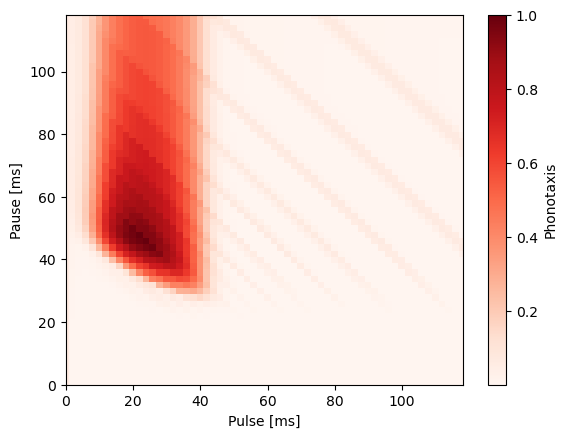

In [188]:
#Printing the result and the closest fit result generated from the model. 

print(result)
xe = sig_diff2(result.x)
plot_field(pdur_i, ppau_i, xe[1])

-2.0
-1.9
-1.8
-1.7
-1.6
-1.5
-1.4
-1.3
-1.2
-1.1
[0.14078053436950722, -1.5, -0.16]


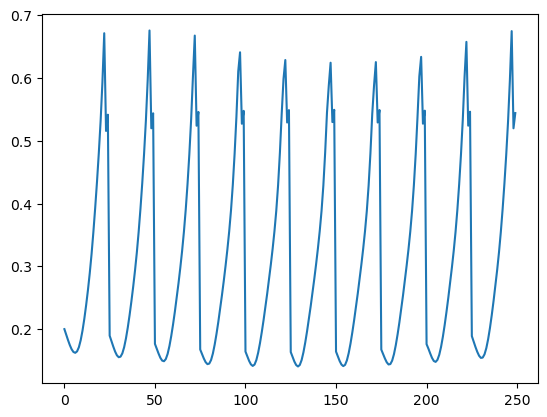

In [77]:
cfg1 = [1,0,0]
vals = []
for i in range(-20, -10):
    i = i/10
    print(i)
    for j in range(-20, 5):
        j = j/100
        cfg = [12, 54, i, j, 0.31, 4.5]
        x = sig_diff(cfg)
        vals.append(x)
        if cfg1[0] > x:
            cfg1 = [x, i, j]
    
print(cfg1)
plt.plot(vals)
plt.show()

In [74]:
# cfg1 = [1,0,0]
# vals = []
# for i in range(10, 15):
#     print(i)
#     for j in range(52, 60):
#         cfg = [i, j, 0.5, -0.16, 0.31, 4.5]
#         x = sig_diff(cfg)
#         vals.append(x)
#         if cfg1[0] > x:
#             cfg1 = [x, i, j]
    
# print(cfg1)
# plt.plot(vals)
# plt.show()